# An Analysis of the Server Room Power Consumption
## 1. Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [61]:
## Import Raw Data, convert to_datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft

from diptest import diptest
from sklearn.cluster import KMeans
from seaborn import kdeplot
from scipy.signal import find_peaks
# import scipy.stats as stats

import mylib

dl1 = pd.read_csv("../data/DL1March_May_24.csv").drop(columns="No.").drop(0)
dl3 = pd.read_csv("../data/DL3March_May_24.csv").drop(columns="No.").drop(0)

dl1["Date/Time"] = pd.to_datetime(dl1["Date/Time"], format='%d/%m/%Y %H:%M', utc=True)
dl3["Date/Time"] = pd.to_datetime(dl3["Date/Time"], format='%d/%m/%Y %H:%M', utc=True)

dl1.set_index(['Date/Time'], inplace=True, drop=False)
dl3.set_index(['Date/Time'], inplace=True, drop=False)

### Key Analyses to Perform
1. **Time-Series Analysis**
    1. Plot Raw Data:
        - Objective: Have a general idea of what the data looks like and have an overview
    1. Important Dates:
        - Objective: Identify overall trends in energy usage. Are there periods of high consumption? How does energy use vary by day or hour?
        - Plot energy consumption over time. Break down by hour, day, week, and month to identify patterns (e.g., higher usage during workdays vs. weekends).
    2. Weather correlation:
        - Objective: Evaluate correlation between temperature and power consumption.
        - Determine relationship between temperature and power consumption: is it inverse, related, independent?. Note that the data from the distribution board to which the AC is plugged in has been lost due to data corruption.
    3. Rates of Change:
        - Objective: Plot rate(s) of change of power consumption over time and identify useful information.
        - Identify whether or not this is useful as an analysis: even coming to the conclusion this isn't interesting is itself interesting.

2. **Statistical Analysis**
    1. Distribution Identification:
        - Objective: Obtain all statistics of this sample set, and use statistical tests to identify the type of distribution.
        - This should give a better idea of the behavior of this dataset. 
    1. Important Dates:
        - Objective: Plot histograms following the same rules as the previous section.

3. **CPU Usage Correlation**
    1. Import Raw Data:
        - Objective: Visualize and have an overview of the all servers available (Bamboo, Bermuda, Pampas, Spinifex)
    2. Obtain Correlation Coefficient:
        - Objective: Align the CPU usage dataset with power consumption in order to obtain an accurate correlation coefficient. 

4. **Frequency Analysis**
    1. FFT:
        - Objective: Identify areas of repetitive behavior and explain any unexpected behavior.

## 2. Time-Series Analysis
This section will consist of plotting every data point we have in time in order to establish a relationship between periods of the year and our variables.

Let's only consider DL1 for now: both datasets we have so far are only sampling servers. Now, time to plot the raw data.
### Raw Data Plotting

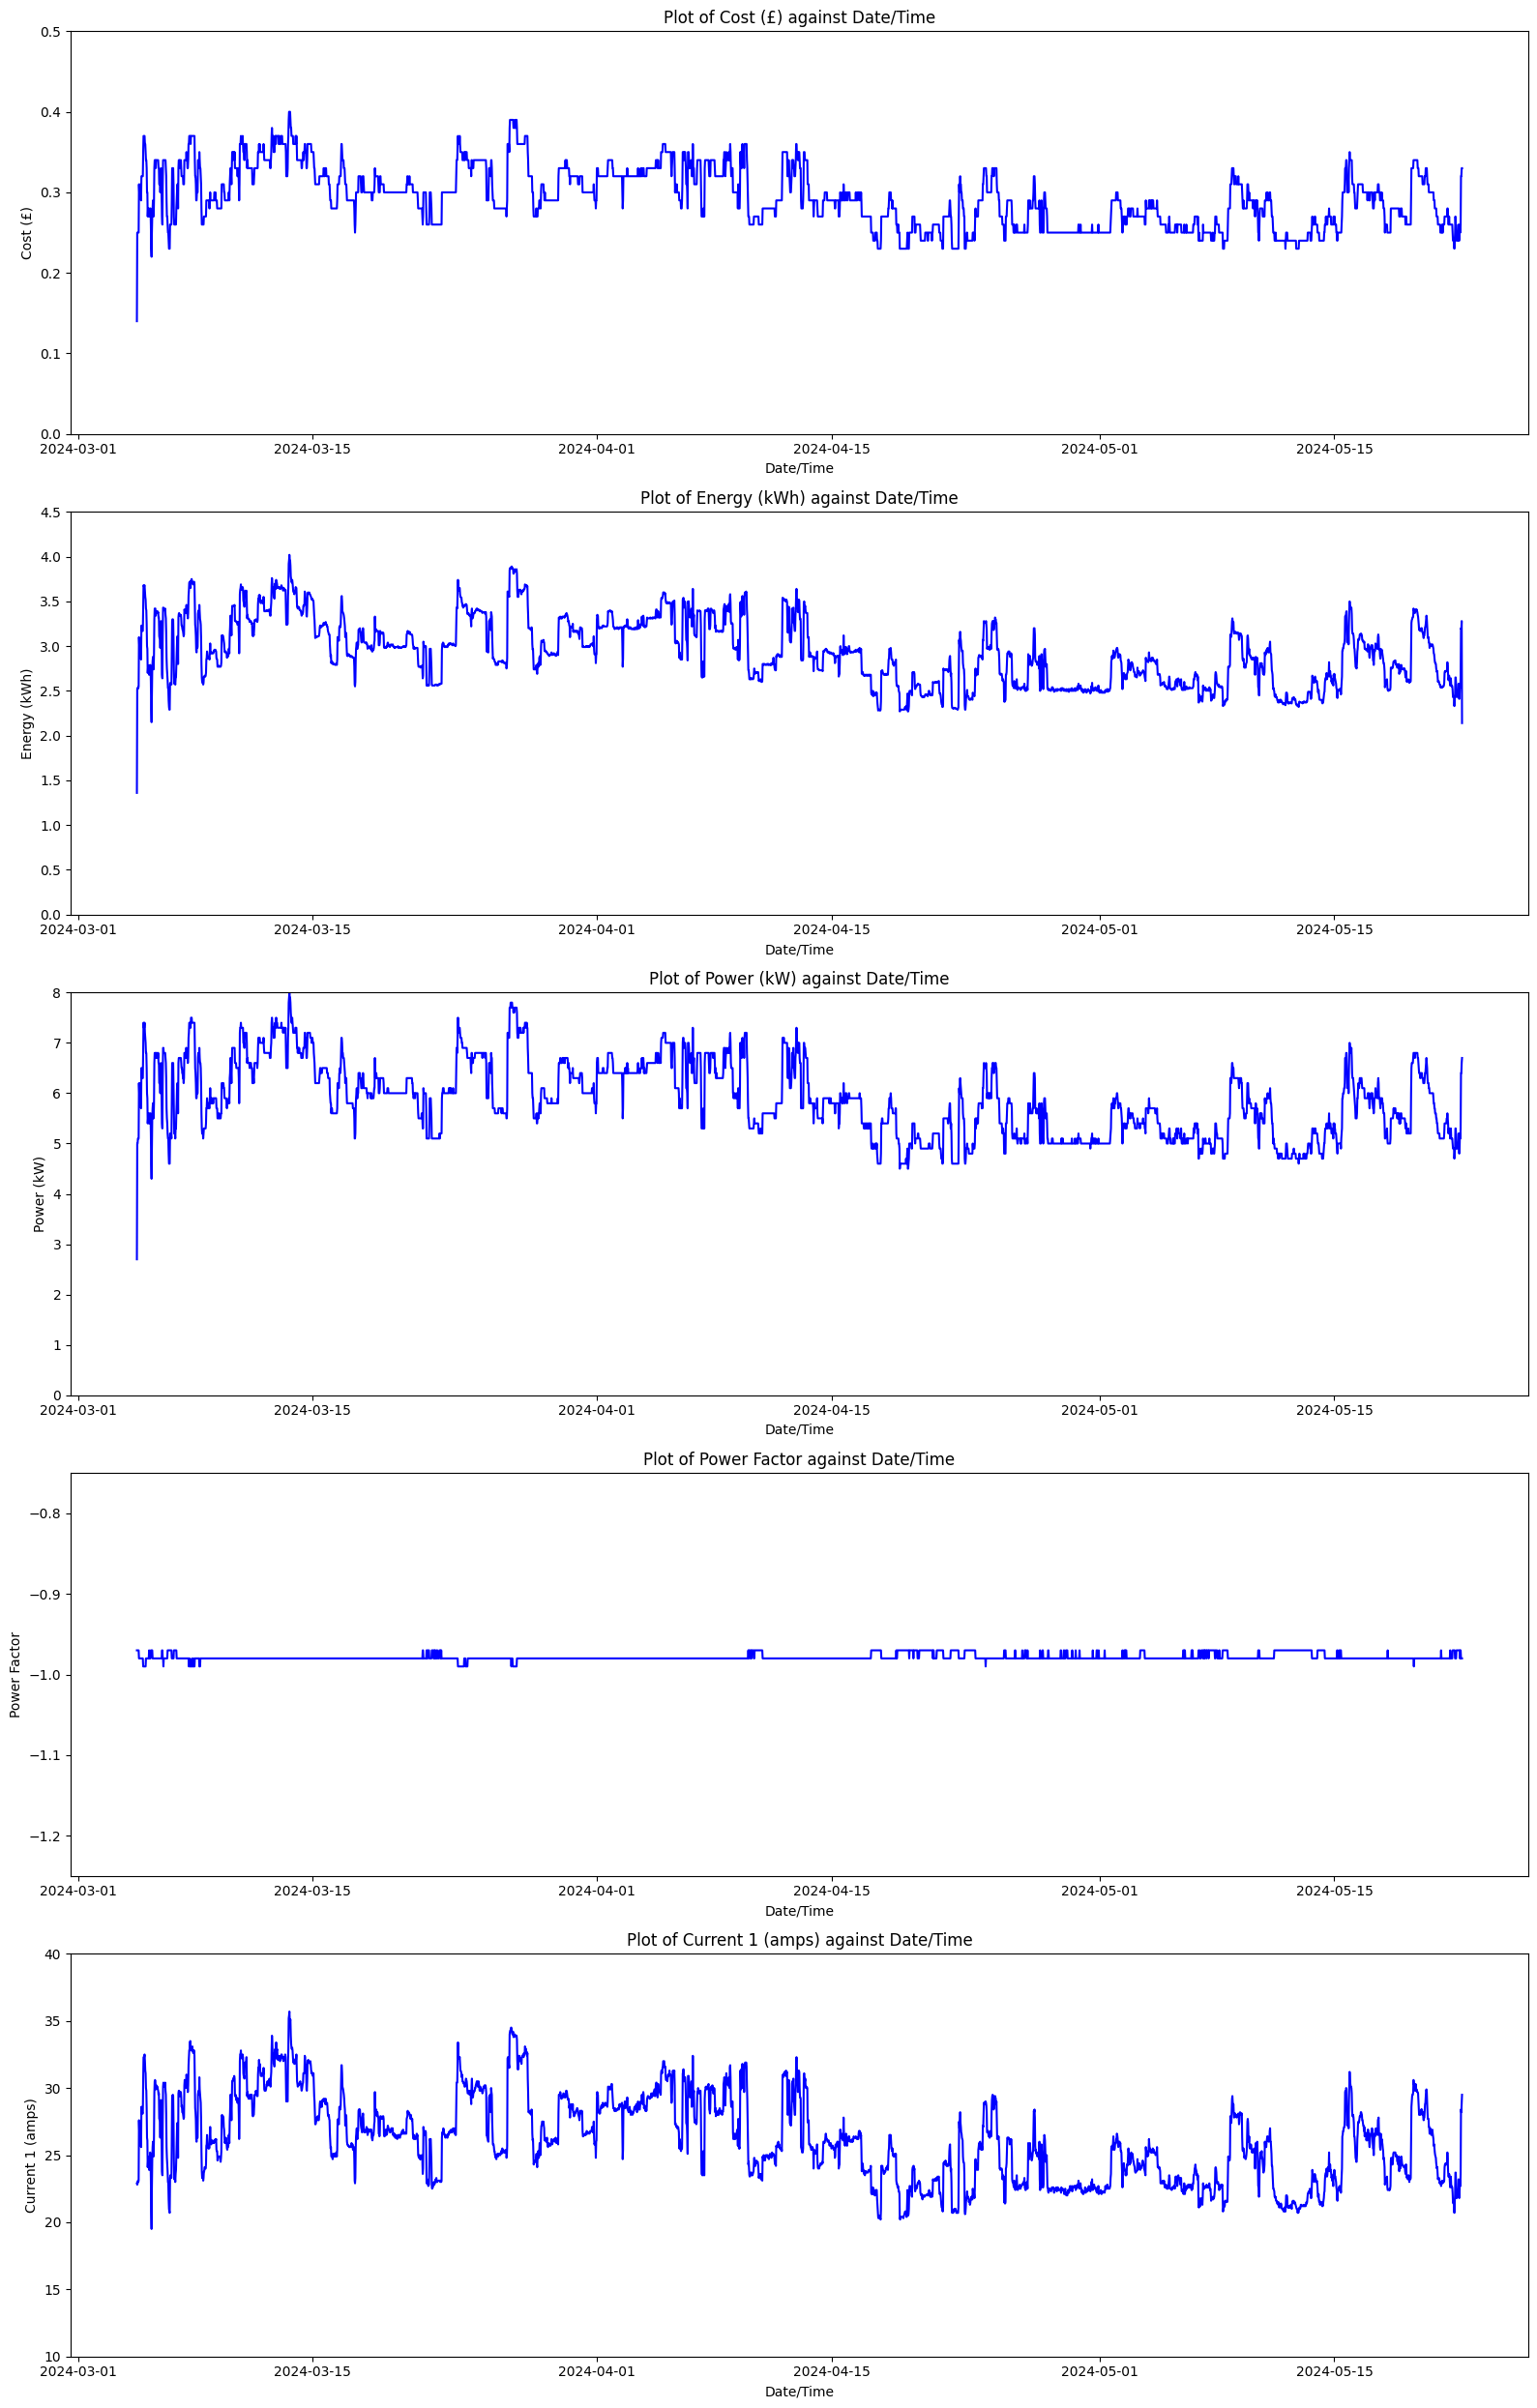

In [62]:
plt.figure(figsize=(16, 5*5))

headers = dl1.columns.values.tolist()
i = 0
for i in range(1, 6):
    match i:
        case 1: vertical_limits = (0, 0.5)
        case 2: vertical_limits = (0, 4.5)
        case 3: vertical_limits = (0, 8)
        case 4: vertical_limits = (-1.25, -0.75)
        case 5: vertical_limits = (10, 40)
    plt.subplot(5, 1, i)
    plt.plot(dl1["Date/Time"], dl1[headers[i]], color='b')
    plt.ylim(vertical_limits)
    plt.xlabel("Date/Time")
    plt.ylabel(headers[i])
    plt.title("Plot of " + headers[i] + " against Date/Time")
    
plt.tight_layout()
plt.show()

Note that most of these are very similar, as proved by the correlation matrix below, where nearly all variables have a correlation coefficient of 1.
This also makes sense intuitively: cost is directly proportional to energy consumed, as per the energy provider; the sampling time is constant at twice per hour, so the energy will also be linearly linked to the power; and finally, assuming the supply voltage stays constant throughout, power and current are also directly proportional to one another. Power factor is separate, but its stableness indicates that our assumption about stable voltage supply is accurate.

In [63]:
print(dl1.drop(columns=["Date/Time"]).corr())

                  Cost (£)  Energy (kWh)  Power (kW)  Power Factor  \
Cost (£)          1.000000      0.995811    0.995801     -0.582129   
Energy (kWh)      0.995811      1.000000    0.997802     -0.585075   
Power (kW)        0.995801      0.997802    1.000000     -0.585427   
Power Factor     -0.582129     -0.585075   -0.585427      1.000000   
Current 1 (amps)  0.994282      0.995574    0.996145     -0.581830   

                  Current 1 (amps)  
Cost (£)                  0.994282  
Energy (kWh)              0.995574  
Power (kW)                0.996145  
Power Factor             -0.581830  
Current 1 (amps)          1.000000  


For this reason, only the power will be plotted in further figures, for ease of readability.

In [64]:
HEADER = "Power (kW)" # DO NOT MODIFY

### Important Dates
During these times, there were bank holidays, campus closure times, as well as a switch from term time to holiday time. As the servers are mostly used by MsC and PhD students, usually overnight, it is expected that the power consumption over that time remains relatively constant. Here, we will distiguish between power consumption on weekends, bank holidays, term time, and campus closure.

To distinguish between which variable is being analysed, a HEADER variable will be defined. It must not be touched at all times.

#### Bank Holidays & Campus Closure
The dates were pulled manually from the official imperial website.

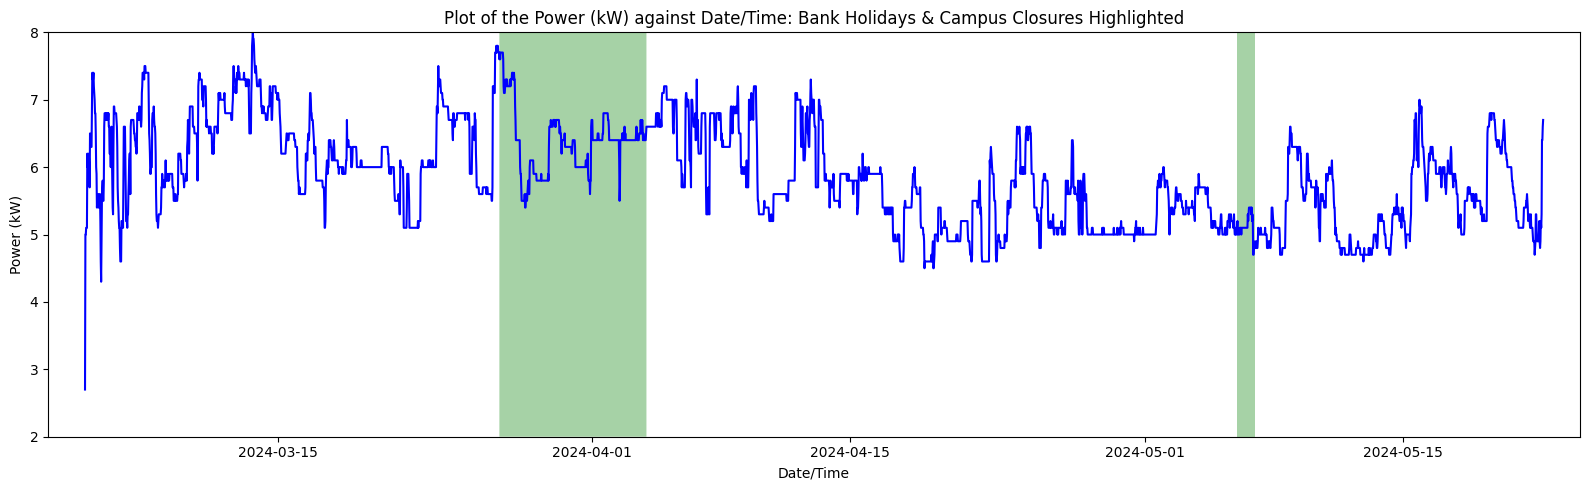

In [65]:
# bank holidays + campus closure
bank_holidays = pd.to_datetime(["27/03/2024", "28/03/2024", "29/03/2024", "30/03/2024", "31/03/2024", "01/04/2024", "02/04/2024", "03/04/2024", 
                 "06/05/2024", "27/05/2024", "26/08/2024"], format='%d/%m/%Y', utc=True)

# initialize figure
plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.normalize() in bank_holidays for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Bank Holidays & Campus Closures Highlighted")
    
plt.tight_layout()
plt.show()

#### Term Time
Again, term time dates were pulled from Imperial's official website.

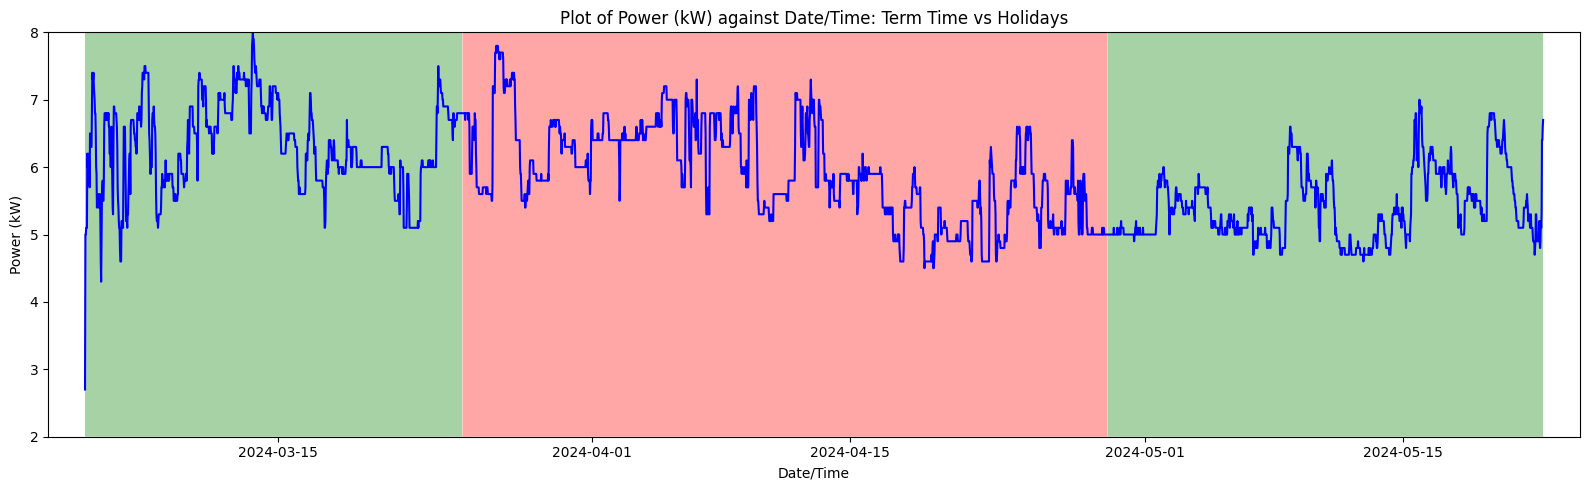

In [66]:
# Term Time relation to power consumption
spring_term = pd.date_range(pd.to_datetime("2024-01-07", utc=True), pd.to_datetime("2024-03-24", utc=True), freq=pd.Timedelta(days=1))
summer_term = pd.date_range(pd.to_datetime("2024-04-29", utc=True), pd.to_datetime("2024-06-30", utc=True), freq=pd.Timedelta(days=1))

plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() not in spring_term and time.normalize() not in summer_term for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1],
                 where=[time.normalize() in spring_term or time.normalize() in summer_term for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of " + HEADER + " against Date/Time: Term Time vs Holidays")
    
plt.tight_layout()
plt.show()

### Weekends vs Weekdays
Here, we will analyse the difference between weekdays, weekends, both individually and as a group. This will include an analysis for each individual day of the week, taking its expected consumption during the day, as well as taking the expected consumption through the week, though the hourly consumption by day will be explored later 

Mean total Power (kW): 5.872274881516588 kW
Median total Power (kW): 5.8 kW

Mean Weekend Power (kW): 5.802935606060607
Mean Weekdays Power (kW): 5.898978847556528
Mean Power (kW) on Monday: 5.881306715063521
Mean Power (kW) on Tuesday: 5.813541666666667
Mean Power (kW) on Wednesday: 5.94293381037567
Mean Power (kW) on Thursday: 6.030681818181819
Mean Power (kW) on Friday: 5.832386363636363
Mean Power (kW) on Saturday: 5.824053030303031
Mean Power (kW) on Sunday: 5.781818181818182
Median Power (kW) on Monday: 6.0
Median Power (kW) on Tuesday: 5.7
Median Power (kW) on Wednesday: 6.0
Median Power (kW) on Thursday: 5.9
Median Power (kW) on Friday: 5.8
Median Power (kW) on Saturday: 5.7
Median Power (kW) on Sunday: 5.8


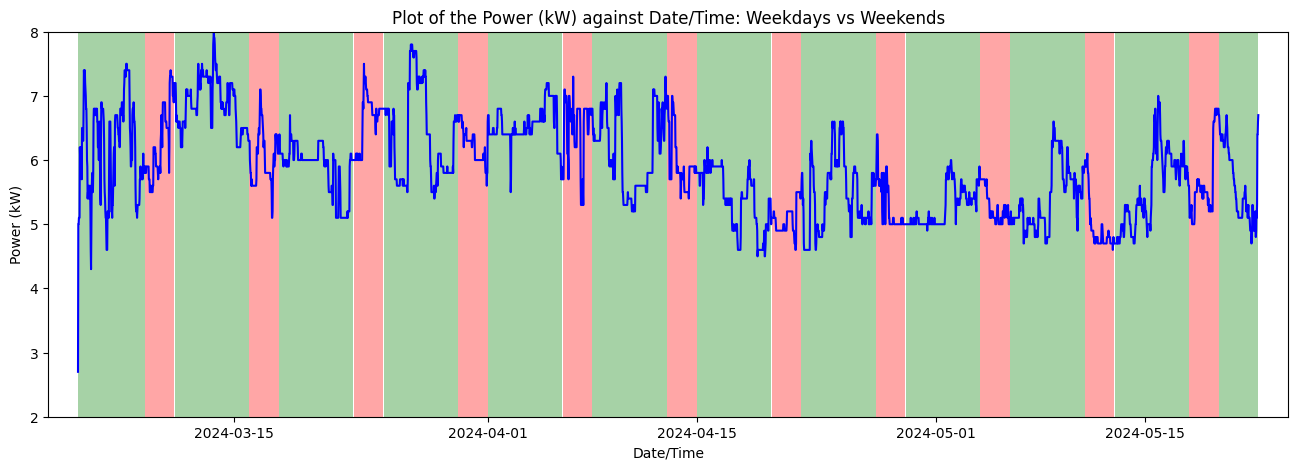

Text(0.5, 1.0, 'Power (kW) for each day of the week')

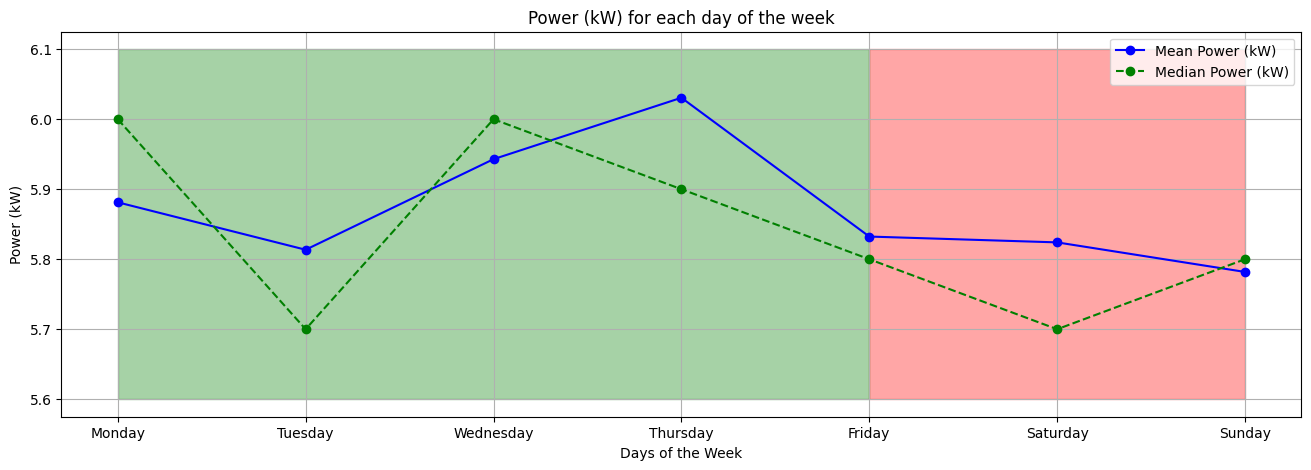

In [67]:
## Mean and median total consumption
days_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

print("Mean total " + HEADER + ": " + str(dl1[HEADER].mean()) + " kW")
print("Median total " + HEADER + ": " + str(dl1[HEADER].median()) + " kW\n")

power_days = dl1[HEADER].groupby(dl1["Date/Time"].dt.weekday).apply(list).to_dict()

power_days["Weekend"] = power_days[5] + power_days[6] # 5 == Saturday, 6 == Sunday
power_days["Weekdays"] = power_days[0] + power_days[1] + power_days[2] + power_days[3] + power_days[4]


print("Mean Weekend " + HEADER + ": " + str(np.mean(power_days['Weekend'])))
print("Mean Weekdays " + HEADER + ": " + str(np.mean(power_days['Weekdays'])))

for i in range(7):
    print("Mean " + HEADER + " on " + days_of_the_week[i] + ": " + str(np.mean(power_days[i])))
for i in range(7):
    print("Median " + HEADER + " on " + days_of_the_week[i] + ": " + str(np.median(power_days[i])))

## FIG1
plt.figure(figsize=(16, 5))
vertical_limits = (2, 8)

plt.plot(dl1["Date/Time"], dl1[HEADER], color='b')
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() == 5 or time.weekday() == 6 for time in dl1["Date/Time"]], 
                 facecolor='r', alpha=0.35)
plt.fill_between(dl1["Date/Time"], vertical_limits[0], vertical_limits[1], step='post',
                 where=[time.weekday() != 5 and time.weekday() != 6 for time in dl1["Date/Time"]], 
                 facecolor='g', alpha=0.35)
plt.ylim(vertical_limits)
plt.xlim(dl1["Date/Time"].iloc[0] - pd.Timedelta(days=2), dl1["Date/Time"].iloc[-1] + pd.Timedelta(days=2))
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.title("Plot of the " + HEADER + " against Date/Time: Weekdays vs Weekends")
    
plt.show()
## FIG2
plt.figure(figsize=(16, 5))
plt.plot([np.mean(power_days[i]) for i in range(7)], color='b', linestyle='-', marker='o', label='Mean ' + HEADER)
plt.plot([np.median(power_days[i]) for i in range(7)], color='g', linestyle='--', marker='o', label='Median ' + HEADER)

plt.fill_between(range(4, 7), 5.6, 6.1, 
                 where=[True]*3, color='r', alpha=0.35)
plt.fill_between(range(5), 5.6, 6.1, 
                 where=[True]*5, color='g', alpha=0.35)

plt.xticks(range(7), days_of_the_week.values())
plt.legend(loc='upper right')
plt.grid()
plt.xlabel("Days of the Week")
plt.ylabel(HEADER)
plt.ylim()
plt.title(HEADER + " for each day of the week")

### Throughout the Day
#### Day vs Night & Working Day vs Night Analysis
Here we will define the day on the clock as 6am-6pm. Alternatively, we will also explore the working day from 9am-5pm, as it could also yield interesting results.

Clock Day Average: 5.803164556962025
Clock Night Average: 5.94071729957806

Working Day Average: 5.800632911392405
Working Night Average: 5.90759493670886


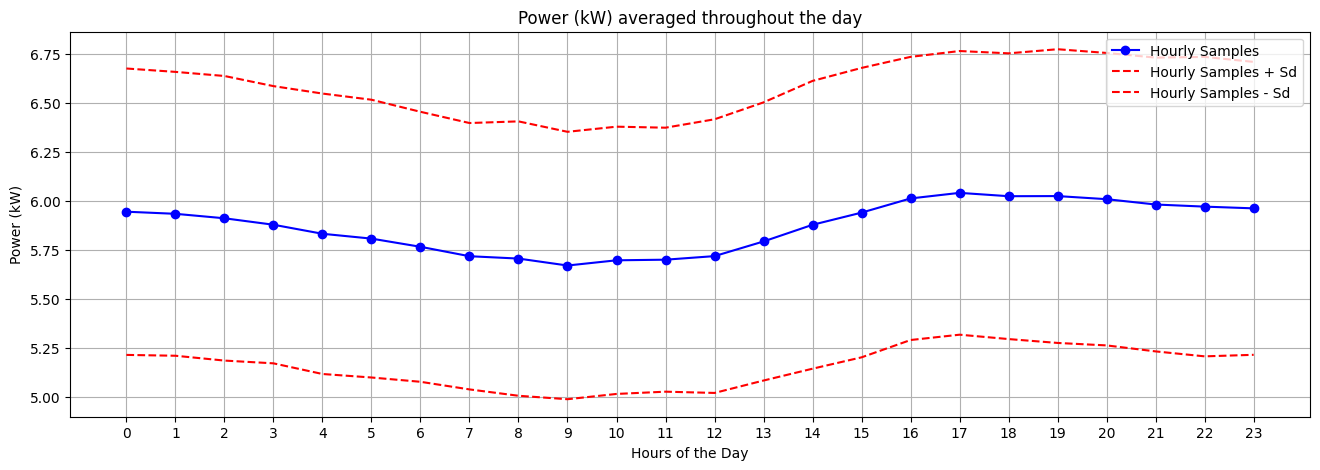

In [68]:
hourly_samples = dl1[HEADER].groupby(dl1["Date/Time"].dt.hour).apply(list).to_dict()
hourly_samples_mean = [np.mean(hourly_samples[i]) for i in range(len(hourly_samples))]
hourly_samples_var = [np.std(hourly_samples[i]) for i in range(len(hourly_samples))]

day_clock = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in range(6, 18)]
day_working = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in range(9, 17)]
night_clock = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in list(range(6))+list(range(18, 24))]
night_working = [hourly_samples[i][j] for j in range(len(hourly_samples[i])) for i in list(range(9))+list(range(17, 24))]

print("Clock Day Average: " + str(np.mean(day_clock)))
print("Clock Night Average: " + str(np.mean(night_clock)))
print("\nWorking Day Average: " + str(np.mean(day_working)))
print("Working Night Average: " + str(np.mean(night_working)))

plt.figure(figsize=(16, 5))
plt.plot(hourly_samples_mean, color='b', linestyle='-', marker='o', label='Hourly Samples')
plt.plot(np.add(hourly_samples_mean, hourly_samples_var), color='r', linestyle='--', label='Hourly Samples + Sd')
plt.plot(np.subtract(hourly_samples_mean, hourly_samples_var), color='r', linestyle='--', label='Hourly Samples - Sd')
plt.xticks(range(24), [str(i) for i in range(24)])
plt.grid()
plt.xlabel("Hours of the Day")
plt.ylabel(HEADER)
plt.title(HEADER + " averaged throughout the day")
plt.legend(loc='upper right')
plt.show()

#### For Each Day of the Week
Explore contract terms and conditions.

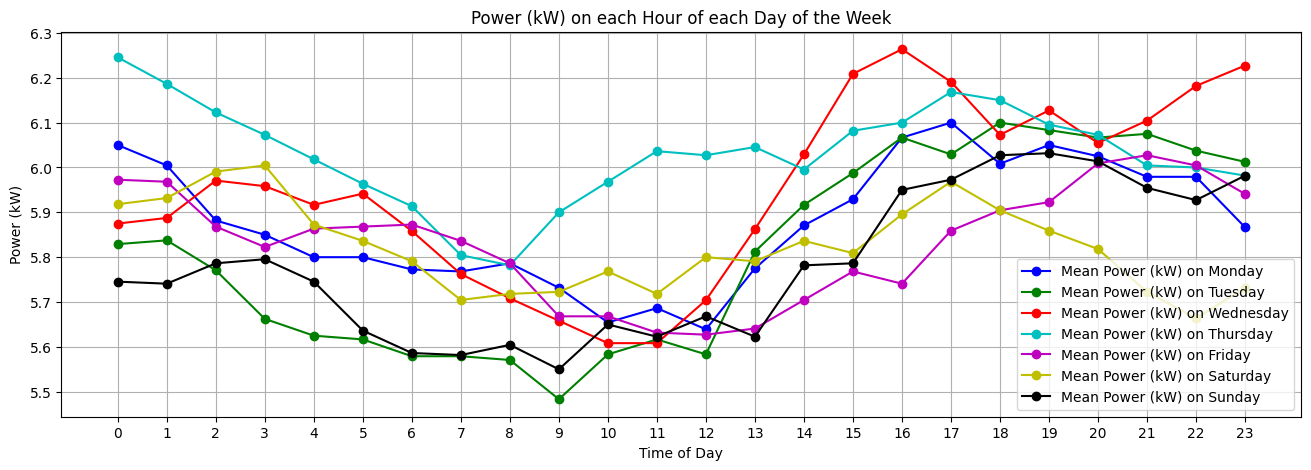

Text(0.5, 1.0, 'Power (kW) for each day of the week, during the day')

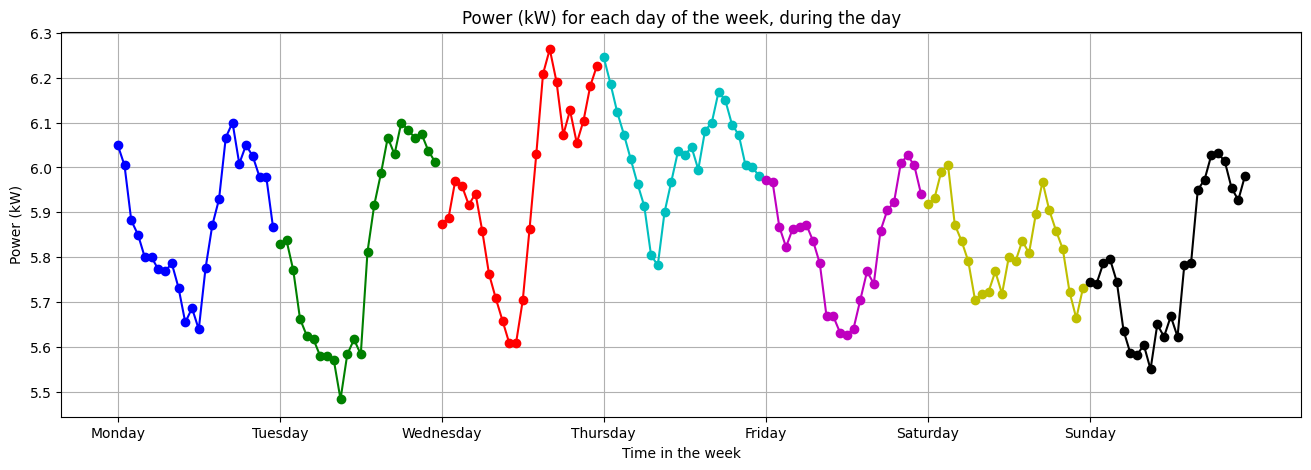

In [69]:
# Group Readings by day of week AND hour using pd.groupby
daily_hourly_samples = dl1.groupby([dl1["Date/Time"].dt.weekday, dl1["Date/Time"].dt.hour])[HEADER].apply(list).to_dict()
days_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k'}

# for individual plots: (VERY time consuming)
# fig, ax = plt.subplots(7, figsize=(16, 20))
# for i in range(7):
#     ax[i].plot([np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], color='b', linestyle='-', marker='o', label='Mean ' + HEADER)
#     # ax[i].plot([np.median(daily_hourly_samples[(i, j)]) for j in range(24)], color='g', linestyle='--', marker='o', label='Median ' + HEADER)
#     ax[i].set_xticks(range(24), [str(i) for i in range(24)])
#     ax[i].set_xlabel(days_of_the_week[i])
#     ax[i].set_ylabel(HEADER)
#     ax[i].set_ylim(5.45, 6.3)
#     ax[i].grid()
#     ax[i].legend(loc='upper right')
# ax[0].set_title(HEADER + " Hourly Average for Each Day of the Week")
# fig.tight_layout()
# plt.show()

plt.figure(figsize=(16, 5))
for i in range(7):
    plt.plot([np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], 
             color=colors[i], linestyle='-', marker='o', label='Mean ' + HEADER + ' on ' + days_of_the_week[i])
plt.xticks(range(24), [str(j) for j in range(24)])
plt.xlabel("Time of Day")
plt.ylabel(HEADER)
plt.legend(loc='lower right')
plt.grid()
plt.title(HEADER + " on each Hour of each Day of the Week")
plt.show()


plt.figure(figsize=(16, 5))
for i in range(7):
    plt.plot(range(i*24, 24*(i+1)), [np.mean(daily_hourly_samples[(i, j)]) for j in range(24)], 
             color=colors[i], linestyle='-', marker='o', label='Mean ' + HEADER + ' on ' + days_of_the_week[i])
plt.xticks(range(0, 24*7, 24), days_of_the_week.values())
plt.grid()
plt.xlabel("Time in the week")
plt.ylabel(HEADER)
plt.title(HEADER+" for each day of the week, during the day")
# build on this: make a color per day and make it fancy

### Weather Correlation 
Weather data was pulled from
https://meteostat.net/en/place/gb/london?s=03779&t=2024-03-04/2024-05-22

To import the data, the same process as before can be used, taking care to import the date and time as a pandas datetime.
Again, we will plot the raw data.

It turns out, the pandas correlation function alignst the series sample by sample, with no regard to when the sample was taken. Therefore, we will modify the power consumption to reflect the average daily power consumption.

The correlation between average temperature and power consumption is: -0.13850431632499344


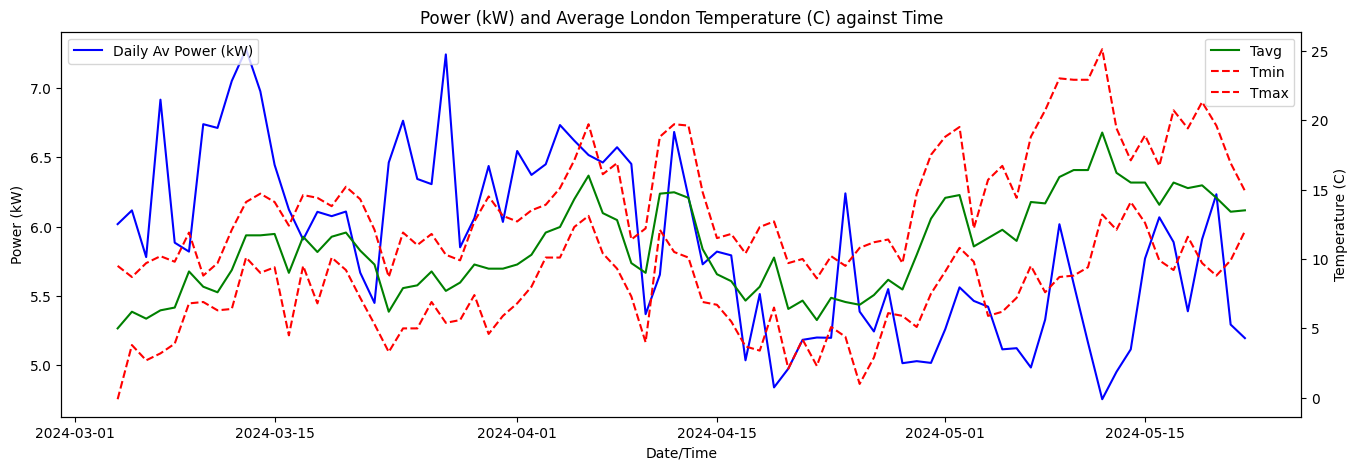

In [70]:
weather = pd.read_csv("../data/London_Daily_Weather.csv").drop(columns=["tsun", "pres"]).fillna(0.0)
weather["date"] = pd.to_datetime(weather["date"], format='%Y-%m-%d', utc=True)
weather.set_index(['date'], inplace=True, drop=False)

dl1_averages = dl1[HEADER].groupby(dl1["Date/Time"].dt.normalize()).mean()

print("The correlation between average temperature and power consumption is: " + str(dl1_averages.corr(weather["tavg"])))

fig, ax = plt.subplots(figsize=(16, 5))
ax.set_xlabel("Date/Time")
ax.set_ylabel(HEADER)
ax.plot(dl1_averages.index, dl1_averages, color='b', linestyle='-', label='Daily Av ' + HEADER)
# ax.plot(dl1["Date/Time"], dl1[HEADER], color='m', linestyle='-', label='regular ' + HEADER, alpha=0.5)
plt.legend(loc='upper left')

ax = ax.twinx()

ax.set_ylabel("Temperature (C)")
ax.plot(weather["date"], weather["tavg"], color='g', label='Tavg', linestyle='-')
ax.plot(weather["date"], weather["tmin"], color='r', label='Tmin', linestyle='--')
ax.plot(weather["date"], weather["tmax"], color='r', label='Tmax', linestyle='--')
plt.title(HEADER+" and Average London Temperature (C) against Time")
plt.legend(loc='upper right')
plt.show()

### Rates of Change
It could be interesting to explore rates of change: to see when the servers have an instant increase in activity. This could allow us to prepare for a period of time we can expect an increase / decrease in activity.

Text(0.5, 1.0, 'Derivative of Power against Date/Time')

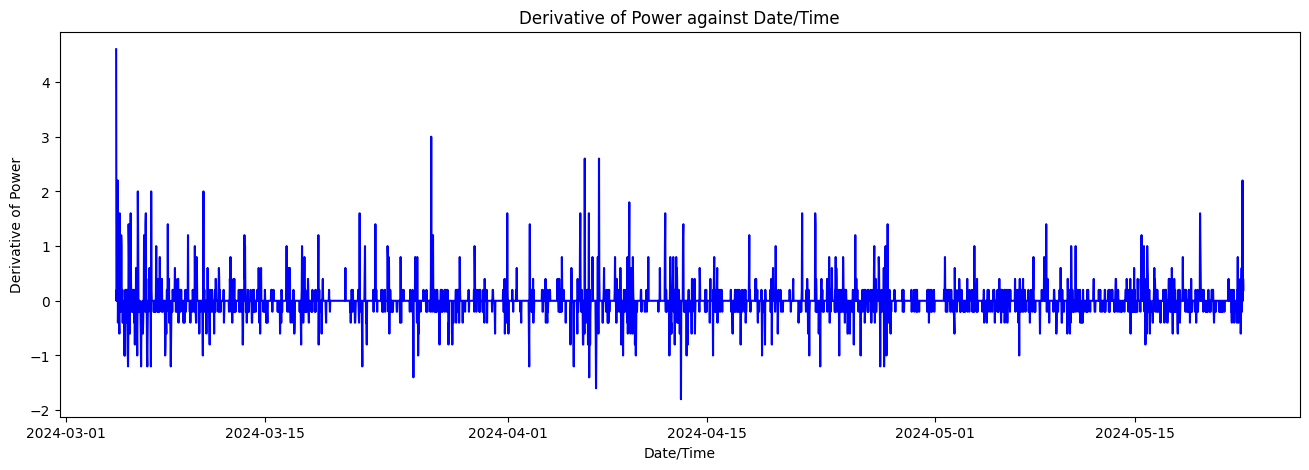

In [71]:
# der = [(dl1[HEADER].iloc[i+1] - dl1[HEADER].iloc[i])*2 for i in range(len(dl1)-1)]
der = dl1[HEADER].rolling(window=2).apply(lambda lst: (lst.iloc[1] - lst.iloc[0])*2)

plt.figure(figsize=(16, 5))
plt.plot(dl1.index, der, color='b', linestyle='-')
plt.xlabel("Date/Time")
plt.ylabel("Derivative of Power")
plt.title("Derivative of Power against Date/Time")

Text(0.5, 1.0, 'Derivative of Power against Date/Time')

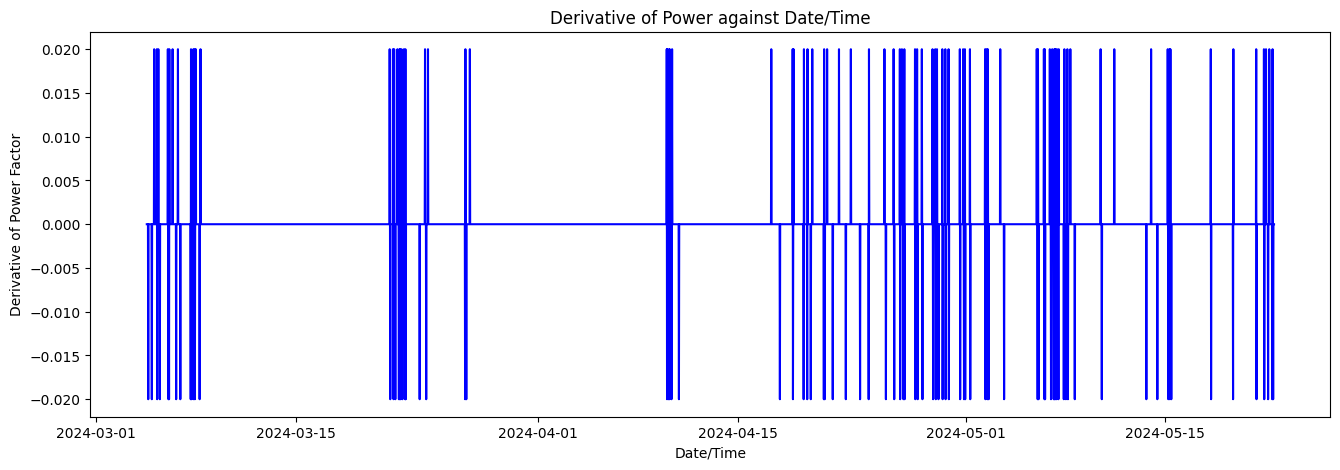

In [72]:
der_pf = dl1['Power Factor'].rolling(window=2).apply(lambda lst: (lst.iloc[1] - lst.iloc[0])*2)

plt.figure(figsize=(16, 5))
plt.plot(dl1.index, der_pf, color='b', linestyle = '-')
plt.xlabel("Date/Time")
plt.ylabel("Derivative of Power Factor")
plt.title("Derivative of Power against Date/Time")

### Moving Average Analysis

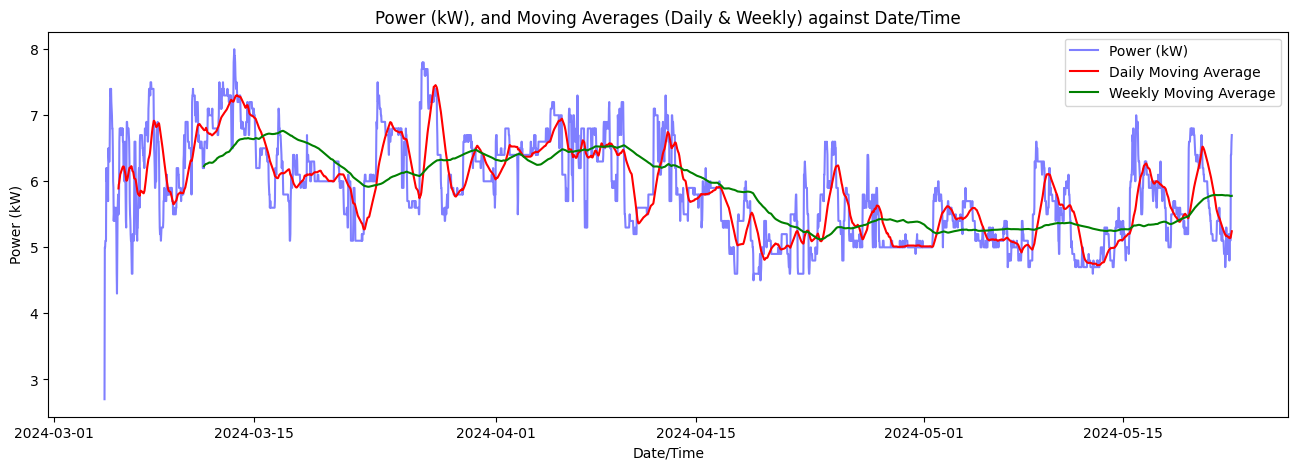

In [73]:
dl1[HEADER + " Moving Av Daily"] = dl1[HEADER].rolling(window=24*2).mean()
dl1[HEADER + " Moving Av Weekly"] = dl1[HEADER].rolling(window=24*2*7).mean()

plt.figure(figsize=(16,5))
plt.plot(dl1["Date/Time"], dl1[HEADER], label=HEADER, color='b', alpha=0.5)
plt.plot(dl1["Date/Time"], dl1[HEADER + " Moving Av Daily"], label='Daily Moving Average', color='r')
plt.plot(dl1["Date/Time"], dl1[HEADER + " Moving Av Weekly"], label='Weekly Moving Average', color='g')
plt.xlabel("Date/Time")
plt.ylabel(HEADER)
plt.legend(loc='upper right')
plt.title(HEADER + ", and Moving Averages (Daily & Weekly) against Date/Time")
plt.show()

## 3. Statistical Analysis
### Determine Type of Distribution
It is unkown what type of distribution this power consumption obeys. My hypothesis is that, as a natural random event, it follows a normal distribution. Let's explore this further. Here, we will analyse current, as it has a higher accuracy: all measures are taken with a precision of up to 0.1, and as most are within a range of 10, this gives them 2 digits of precision, while current current has 3. 

As the first sample has a significantly low current value, it is considered an outlier and removed for clarity for this part of the study.

#### Full Dataset

DATASET STATISTICS:
Mean: 26.150026329647183
Standard Deviation: 3.1635477696953713
Minimum Value: 19.5
25th Percentile: 23.4
Median: 26.0
75th Percentile: 28.5
Maximum: 35.7
Skewness: 0.295968242120477
Kurtosis: -0.7457128257012542

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9751, p=3.1660290621743946e-25
DAgostino and Pearsons Test: stat=300.1416, p=6.684774015680118e-66
Kolmogorov-Smirnov Test: stat=0.06259205114291694, p=2.2286907040033107e-13

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 5.468035445216881e-47
p value for chi2 = 0.0
p value for expon = 1.0760215512017539e-204
p value for exponpow = 0.0
p value for gamma = 3.8393726193608177e-11
p value for lognorm = 2.5771298253181037e-12
p value for norm = 2.1626775794172788e-13
p value for powerlaw = 2.8914093011978126e-159
p value for rayleigh = 3.471757141676038e-08
p value for uniform = 1.2557291730443951e-173
p value for arcsine = 2.2730941667627924e-289
p value for cosine = 2.359466255639068e-30
p va

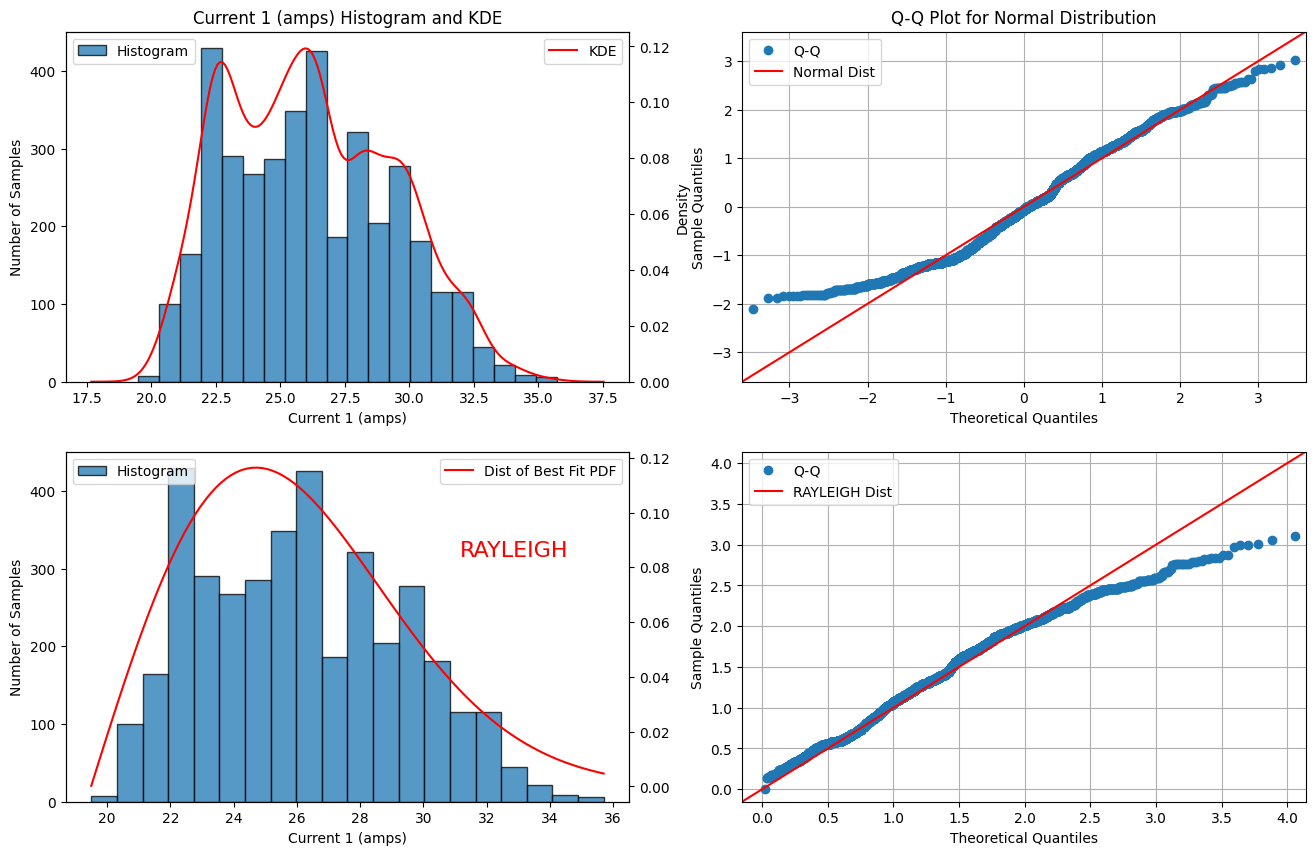

In [74]:
HEADER = 'Current 1 (amps)'
mylib.statistical_analysis(dl1[HEADER], bins=20, header=HEADER)

### Determining Multmodality
We can easily observe 3 distinct peaks on the histogram of the full data: this makes me think the distribution is in reality multimodal. Therefore, in this section, I will use the same function in order to identify whether or not this is true by separating the dataset into various chunks of my choosing, depending on variables we have previously studied, such as, but not limited to, days of the week, and time of day. To prove this multimodality, we can use Hartigan's Dip Test, where a result of a low p-value indicates evidence against unimodality.

Dip: 0.023048568072264682; p = 0.0	<- An extremely low p (approximated as 0) indicates multimodality
Cluster centers (modes): [22.77635688 26.42594595 30.3938335 ]
Modes: [22.66206296 25.95402099 28.34817228]


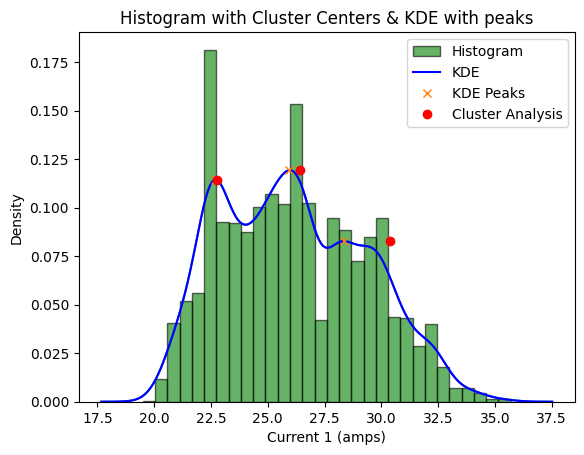

In [75]:
## DETERMINE MULTIMODALITY AND PLOT
dip, p_value = diptest(dl1[HEADER])
print(f'Dip: {dip}; p = {p_value}\t<- An extremely low p '+('(approximated as 0) ' if p_value == 0 else '') + 'indicates multimodality')

##
reshaped = np.array(dl1[HEADER]).reshape(-1, 1)
# Apply k-means clustering with k=3 (assuming three modes for simplicity)
kmeans = KMeans(n_clusters=3)
kmeans.fit(reshaped)

# Cluster centers represent modes
print("Cluster centers (modes):", cluster_centers := np.sort(kmeans.cluster_centers_.flatten()))

x_kde, y_kde = kdeplot(dl1[HEADER]).lines[0].get_data()
peaks, _ = find_peaks(y_kde)
print("Modes:", MODES:=np.sort(x_kde[peaks]))

# Plot the results
plt.hist(dl1[HEADER], bins=30, alpha=0.6, color='g', edgecolor='k', label='Histogram', density=True)
plt.legend(loc='upper left')
plt.title('Histogram with Cluster Centers & KDE with peaks')
plt.plot(x_kde, y_kde, '-b', label='KDE')
plt.plot(x_kde[peaks], y_kde[peaks], "x", label='KDE Peaks')
plt.plot(cluster_centers, y_kde[peaks], 'o', color='r', label='Cluster Analysis')
plt.legend(loc='upper right')
plt.show()

We can conclude that there are at the very least two noticeable modes: one near **22.7A** and the other near **26.2A**. There is some ambiguity as to the location of the other mode, but this is already a lot to work from. From now on, we will try to manually isolate the distributions in order to identify the modes.
We will also mark the known modes in every subsequent statistical analysis.

#### On Bank Holidays
In order to streamline the testing process, I had an idea to make a testing suite that takes in a Series or DataFrame and obtains all the required information we need to make a statement about the subsets of the dataset we will be analysing.

DATASET STATISTICS:
Mean: 27.718287037037037
Standard Deviation: 2.62126521455139
Minimum Value: 21.1
25th Percentile: 26.1
Median: 28.3
75th Percentile: 28.9
Maximum: 34.0
Skewness: -0.1385749516907255
Kurtosis: 0.24925905865706044

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9572, p=7.142027955141754e-10
DAgostino and Pearsons Test: stat=2.7130, p=0.2575597189638062
Kolmogorov-Smirnov Test: stat=0.14347154041208854, p=3.1897259880685206e-08

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 1.1536362847259953e-08
p value for chi2 = 5.55050938880556e-152
p value for expon = 2.66986747246645e-44
p value for exponpow = 5.5850950929e-313
p value for gamma = 7.996356347888919e-09
p value for lognorm = 3.133930466304905e-08
p value for norm = 3.1369068180201736e-08
p value for powerlaw = 2.823004986081922e-27
p value for rayleigh = 4.139327518634974e-17
p value for uniform = 7.787356761360978e-16
p value for arcsine = 4.755344276133606e-28
p value for cosine = 7.14675380

c:\Users\ogahe\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis_eeedept\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for weibull_max = 2.901894099649765e-213
p value for weibull_min = 2.526308453678889e-07
p value for pareto = 2.669832036850563e-44
p value for genextreme = 1.5916577060279658e-07

Best fitting distribution: dweibull
Best p value: 5.441713807115236e-07
Parameters for the best fit: (0.9480083919588569, 28.299999999999997, 1.8997600759939832)


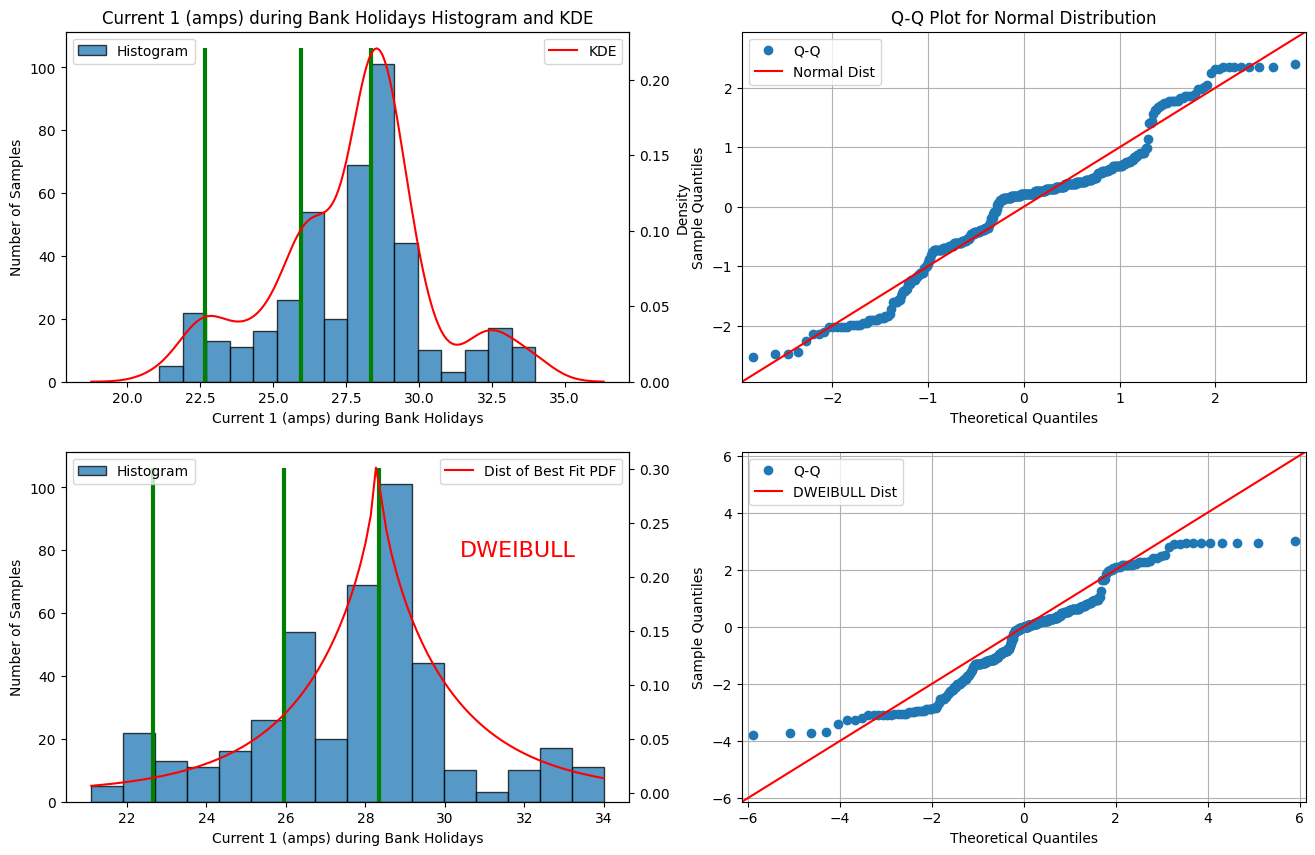

In [76]:
dl1_bank_holidays = pd.Series([val for i, val in enumerate(dl1[HEADER]) if dl1.index[i].normalize() in bank_holidays])
mylib.statistical_analysis(dl1_bank_holidays, bins=16, header=HEADER+' during Bank Holidays', modes=MODES)

##### Conclusions


#### Non-Bank Holidays

DATASET STATISTICS:
Mean: 27.718287037037037
Standard Deviation: 2.62126521455139
Minimum Value: 21.1
25th Percentile: 26.1
Median: 28.3
75th Percentile: 28.9
Maximum: 34.0
Skewness: -0.1385749516907255
Kurtosis: 0.24925905865706044

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9572, p=7.142027955141754e-10
DAgostino and Pearsons Test: stat=2.7130, p=0.2575597189638062
Kolmogorov-Smirnov Test: stat=0.14347154041208854, p=3.1897259880685206e-08

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 1.1536362847259953e-08
p value for chi2 = 5.55050938880556e-152
p value for expon = 2.66986747246645e-44
p value for exponpow = 5.5850950929e-313
p value for gamma = 7.996356347888919e-09
p value for lognorm = 3.133930466304905e-08
p value for norm = 3.1369068180201736e-08
p value for powerlaw = 2.823004986081922e-27
p value for rayleigh = 4.139327518634974e-17
p value for uniform = 7.787356761360978e-16
p value for arcsine = 4.755344276133606e-28
p value for cosine = 7.14675380

c:\Users\ogahe\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis_eeedept\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for weibull_max = 2.901894099649765e-213
p value for weibull_min = 2.526308453678889e-07
p value for pareto = 2.669832036850563e-44
p value for genextreme = 1.5916577060279658e-07

Best fitting distribution: dweibull
Best p value: 5.441713807115236e-07
Parameters for the best fit: (0.9480083919588569, 28.299999999999997, 1.8997600759939832)


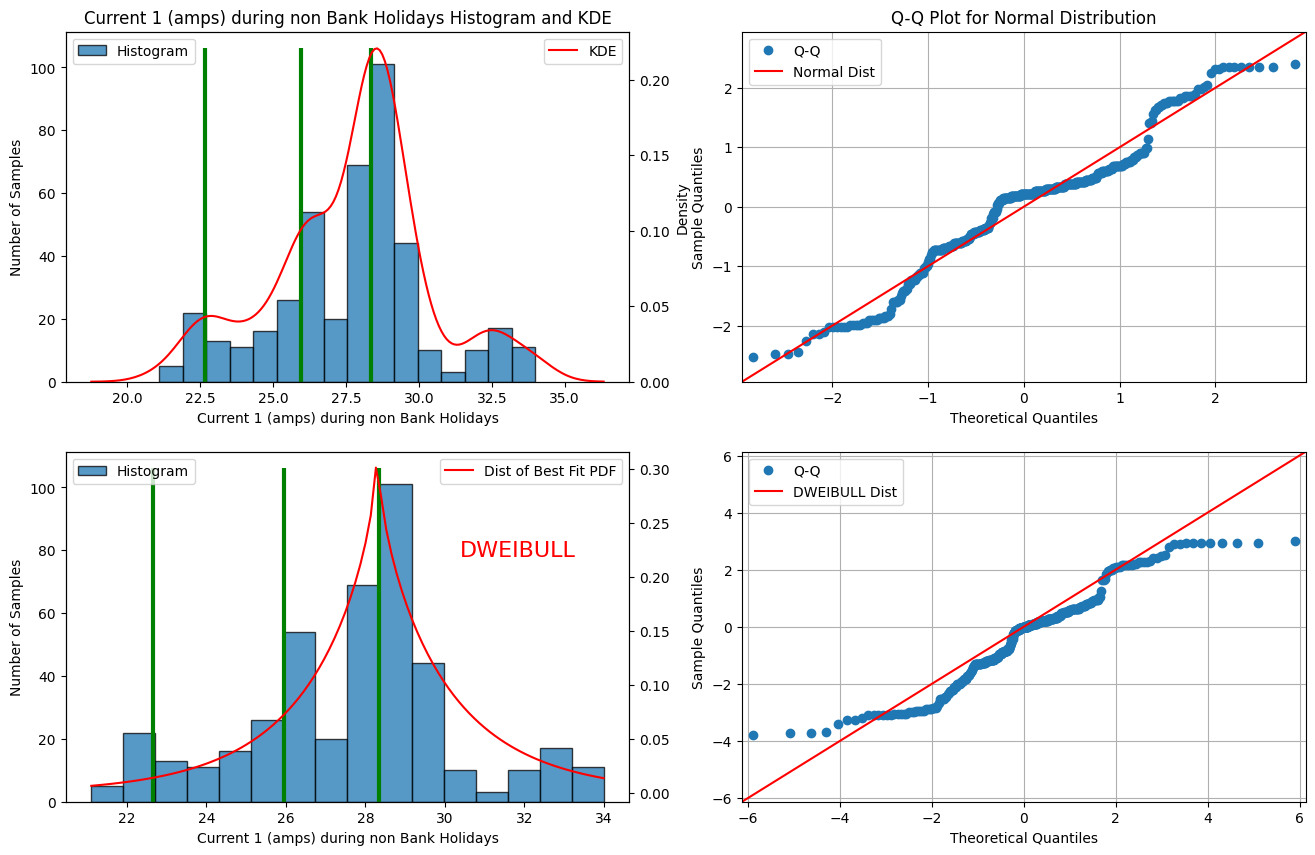

In [77]:
dl1_bank_holidays_not = pd.Series([val for i, val in enumerate(dl1[HEADER]) if dl1.index[i].normalize() not in bank_holidays])
mylib.statistical_analysis(dl1_bank_holidays, bins=16, header=HEADER+' during non Bank Holidays', modes=MODES)

##### Conclusions


#### During Term Time

DATASET STATISTICS:
Mean: 25.954579792256848
Standard Deviation: 3.2009759028904483
Minimum Value: 19.5
25th Percentile: 23.1
Median: 25.7
75th Percentile: 28.1
Maximum: 35.7
Skewness: 0.42349071182670917
Kurtosis: -0.7206420427247049

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9609, p=1.8598477272383036e-23
DAgostino and Pearsons Test: stat=179.8196, p=8.9673605146969e-40
Kolmogorov-Smirnov Test: stat=0.08495790053390628, p=9.504565647170984e-14

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 6.085999644721236e-35
p value for chi2 = 0.0
p value for expon = 1.664266570759622e-120
p value for exponpow = 1.0055976621708862e-07
p value for gamma = 2.3962173485458175e-08
p value for lognorm = 6.618651952506984e-10
p value for norm = 9.131515056600289e-14
p value for powerlaw = 6.315357670741761e-81
p value for rayleigh = 0.0003737087619788025
p value for uniform = 4.126395339237128e-97
p value for arcsine = 1.0268050951078987e-157
p value for cosine = 1.1685724739946

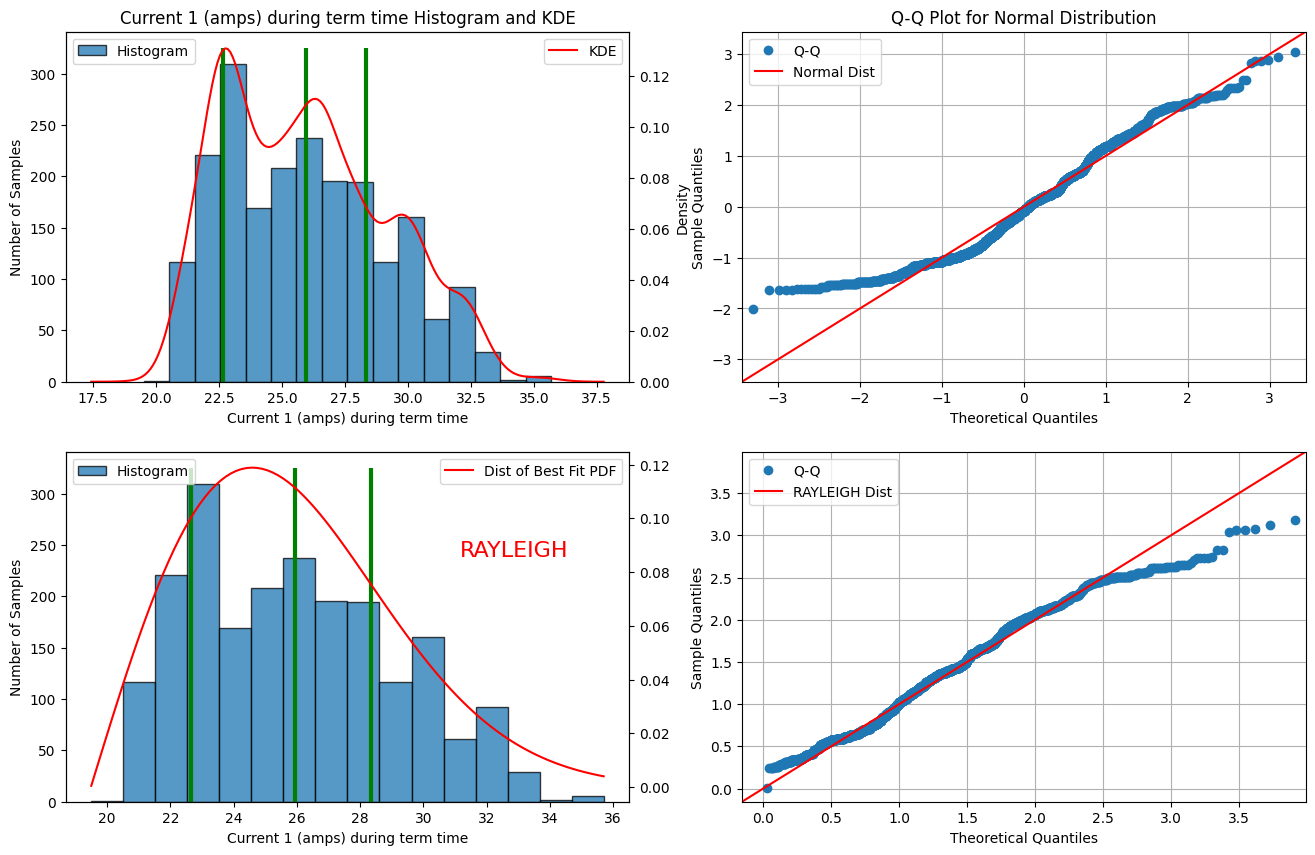

In [78]:
dl1_term_time = pd.Series([val for i, val in enumerate(dl1[HEADER]) 
                           if dl1.index[i].normalize() in summer_term or dl1.index[i].normalize() in spring_term])
mylib.statistical_analysis(dl1_term_time, bins=16, header=HEADER+' during term time', modes=MODES)

##### Conclusions


#### Off-Term Time

DATASET STATISTICS:
Mean: 26.396428571428572
Standard Deviation: 3.0982001852293375
Minimum Value: 20.2
25th Percentile: 24.1
Median: 26.1
75th Percentile: 28.8
Maximum: 34.5
Skewness: 0.13942694578298537
Kurtosis: -0.7001763772763239

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9836, p=6.444743209887579e-13
DAgostino and Pearsons Test: stat=92.0550, p=1.0245168414160558e-20
Kolmogorov-Smirnov Test: stat=0.06587847369675137, p=8.782780076530244e-07

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 1.9314811455527807e-17
p value for chi2 = 2.556000612377279e-09
p value for expon = 1.4431704102356506e-72
p value for exponpow = 0.0
p value for gamma = 6.2071000403584715e-09
p value for lognorm = 6.711533438392757e-09
p value for norm = 8.566401371090728e-07
p value for powerlaw = 3.7164613295247856e-47
p value for rayleigh = 8.067242888528293e-11
p value for uniform = 7.281394444897945e-56
p value for arcsine = 2.484359305759075e-104
p value for cosine = 1.058616014702

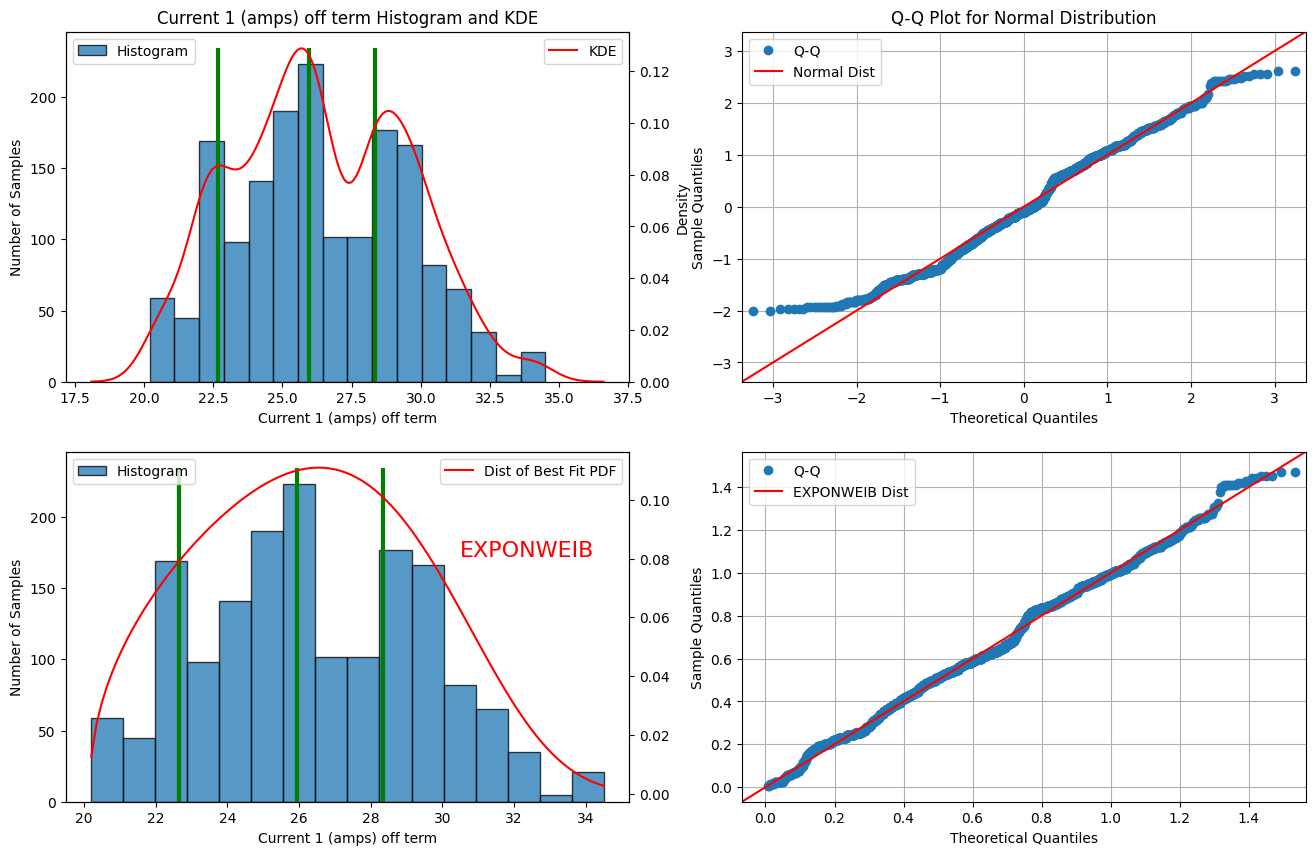

In [79]:
dl1_term_time_not = pd.Series([val for i, val in enumerate(dl1[HEADER])
                               if dl1.index[i].normalize() not in summer_term and dl1.index[i].normalize() not in spring_term])
mylib.statistical_analysis(dl1_term_time_not, bins=16, header=HEADER+' off term', modes=MODES)

##### Conclusions


#### Weekends

DATASET STATISTICS:
Mean: 25.795454545454547
Standard Deviation: 3.0368722355750517
Minimum Value: 20.7
25th Percentile: 23.1
Median: 25.5
75th Percentile: 28.3
Maximum: 33.4
Skewness: 0.2664293368014098
Kurtosis: -0.9965606123367401

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9591, p=1.285107639993929e-16
DAgostino and Pearsons Test: stat=234.5914, p=1.1458494369832116e-51
Kolmogorov-Smirnov Test: stat=0.08404341831590273, p=6.153743916995009e-07

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 7.38007353635058e-17
p value for chi2 = 0.00025151934843101615
p value for expon = 1.9699663468900393e-25
p value for exponpow = 0.0
p value for gamma = 0.0002515252433293665
p value for lognorm = 2.771718416178462e-05
p value for norm = 5.91513893075552e-07
p value for powerlaw = 6.838041141662604e-16
p value for rayleigh = 1.2060044257858944e-05
p value for uniform = 3.0806342710496496e-33
p value for arcsine = 1.661061651889984e-63
p value for cosine = 1.841022202038784

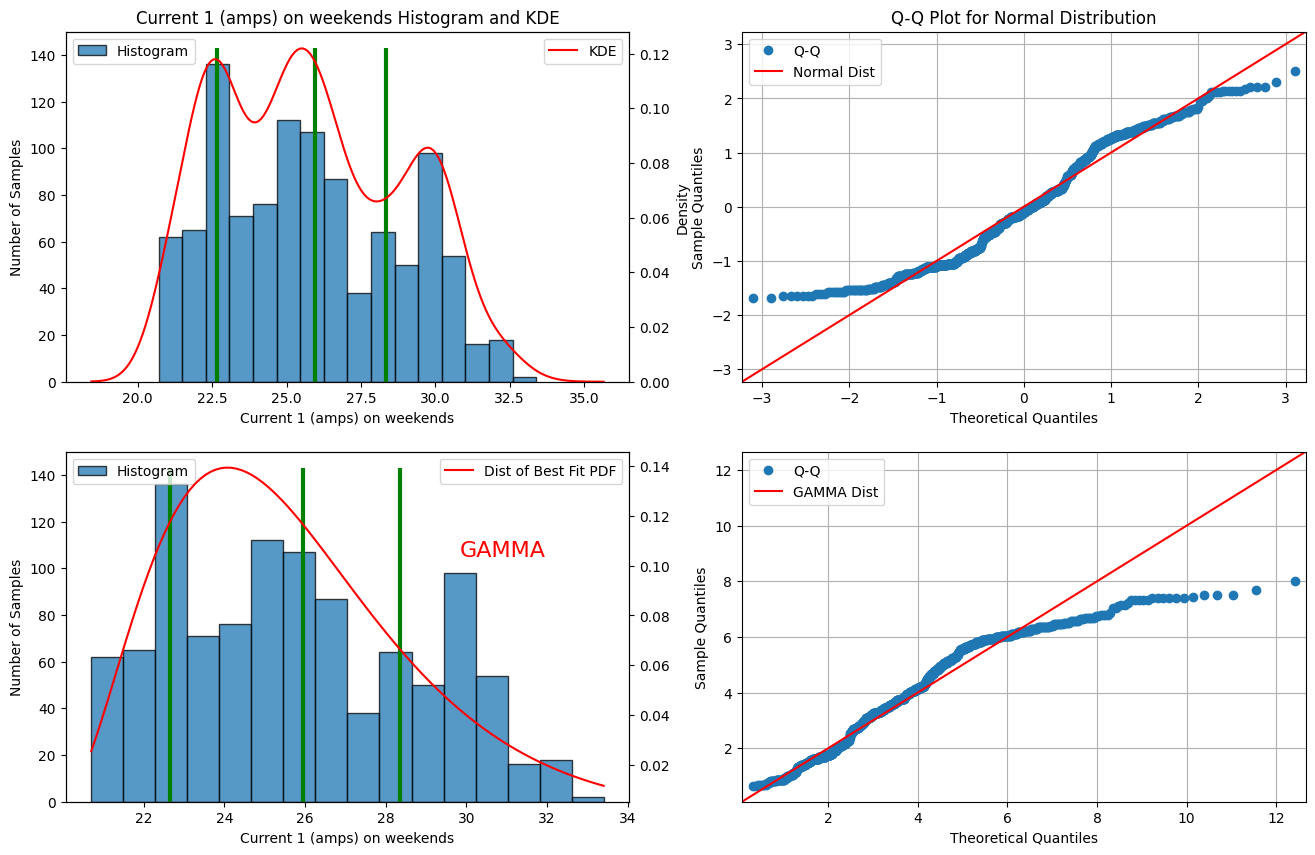

In [80]:
# call this again to make sure we have the same HEADER - time loss but oh well
daily_samples = dl1[HEADER].groupby(dl1["Date/Time"].dt.weekday).apply(list)

dl1_weekends = []
for i in (5, 6):
    dl1_weekends += daily_samples[i]
dl1_weekends = pd.Series(dl1_weekends)
mylib.statistical_analysis(dl1_weekends, bins=16, header=HEADER+' on weekends', modes=MODES)

##### Conclusions


#### Weekdays

DATASET STATISTICS:
Mean: 26.28657913931437
Standard Deviation: 3.200540510533312
Minimum Value: 19.5
25th Percentile: 23.6
Median: 26.2
75th Percentile: 28.6
Maximum: 35.7
Skewness: 0.2959327905612448
Kurtosis: -0.6930353874974955

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9780, p=3.44026456377672e-20
DAgostino and Pearsons Test: stat=176.6039, p=4.476693424142885e-39
Kolmogorov-Smirnov Test: stat=0.057520821680176526, p=2.506636283216106e-08

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 1.5419199013462125e-31
p value for chi2 = 0.0
p value for expon = 1.6596051821911446e-153
p value for exponpow = 0.0
p value for gamma = 1.7302210182046848e-07
p value for lognorm = 2.3997140166407012e-08
p value for norm = 2.4435784641896598e-08
p value for powerlaw = 7.9391817114551945e-109
p value for rayleigh = 6.681343104178206e-07
p value for uniform = 7.896822150338058e-114
p value for arcsine = 3.179024075557497e-189
p value for cosine = 1.6593275014250348e-18
p value

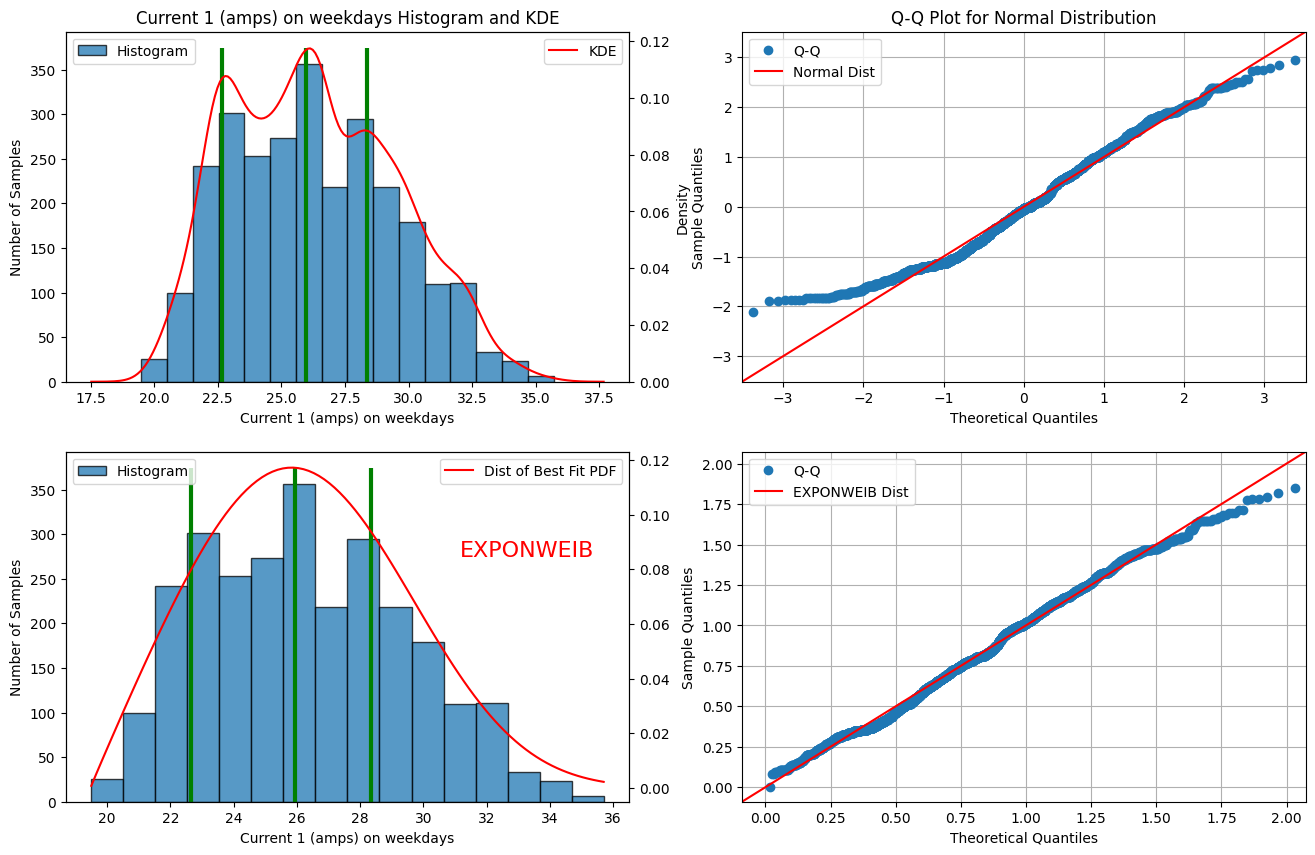

In [81]:
dl1_weekdays = []
for i in range(5):
    dl1_weekdays += daily_samples[i]
dl1_weekdays = pd.Series(dl1_weekdays)
mylib.statistical_analysis(dl1_weekdays, bins=16, header=HEADER+' on weekdays', modes=MODES)

##### Conclusions


#### Working Days

DATASET STATISTICS:
Mean: 26.094771241830067
Standard Deviation: 3.1452344734857953
Minimum Value: 19.5
25th Percentile: 23.3
Median: 26.1
75th Percentile: 28.6
Maximum: 35.7
Skewness: 0.359595868259303
Kurtosis: -0.6142662550694902

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9724, p=3.4815838404070002e-12
DAgostino and Pearsons Test: stat=49.4142, p=1.861382017509517e-11
Kolmogorov-Smirnov Test: stat=0.07445894875660261, p=7.150725307059522e-05

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 1.5498606126762733e-12
p value for chi2 = 0.0
p value for expon = 3.855253329681969e-56
p value for exponpow = 0.0
p value for gamma = 0.00026123734327050826
p value for lognorm = 6.550739649796728e-05
p value for norm = 6.896711147765707e-05
p value for powerlaw = 4.5574763696034535e-39
p value for rayleigh = 0.0014303943804477336
p value for uniform = 1.811698627020195e-45
p value for arcsine = 1.079480705133852e-73
p value for cosine = 2.8076726366424986e-08
p value for e

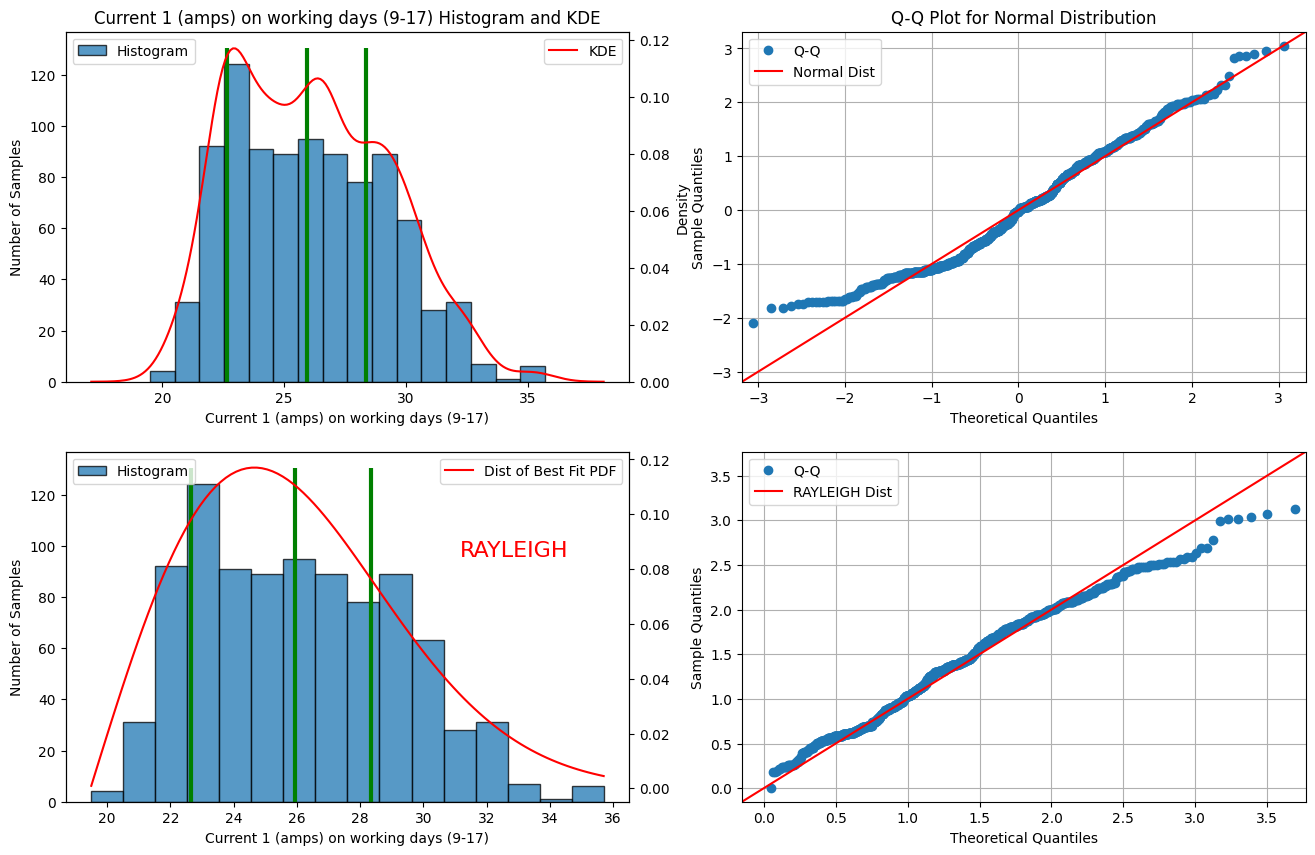

In [82]:
# WEEK DAYS, 9-17
daily_hourly_samples = dl1[HEADER].groupby([dl1["Date/Time"].dt.weekday, dl1["Date/Time"].dt.hour]).apply(list)

dl1_working_days = []
for i in range(5):
    for j in range(9, 17):
        dl1_working_days += daily_hourly_samples[i][j]
dl1_working_days = pd.Series(dl1_working_days)
mylib.statistical_analysis(dl1_working_days, bins=16, header=HEADER+' on working days (9-17)', modes=MODES)

##### Conclusions


#### Working Night

DATASET STATISTICS:
Mean: 26.38311403508772
Standard Deviation: 3.2237026419690302
Minimum Value: 20.2
25th Percentile: 23.8
Median: 26.2
75th Percentile: 28.6
Maximum: 34.5
Skewness: 0.26302708406320136
Kurtosis: -0.7256397246419981

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9787, p=8.008304963030204e-16
DAgostino and Pearsons Test: stat=126.8964, p=2.7847735664773947e-28
Kolmogorov-Smirnov Test: stat=0.0556960684035811, p=2.330747520542022e-05

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 3.2445974348884946e-20
p value for chi2 = 4.311440045149127e-05
p value for expon = 1.5824786037721374e-63
p value for exponpow = 0.0
p value for gamma = 4.310988471916319e-05
p value for lognorm = 0.00013553917784131476
p value for norm = 2.2729995043968017e-05
p value for powerlaw = 1.2635881922220582e-37
p value for rayleigh = 0.00012444818444021217
p value for uniform = 5.293508578336238e-46
p value for arcsine = 4.8037731704286385e-92
p value for cosine = 2.43577964007

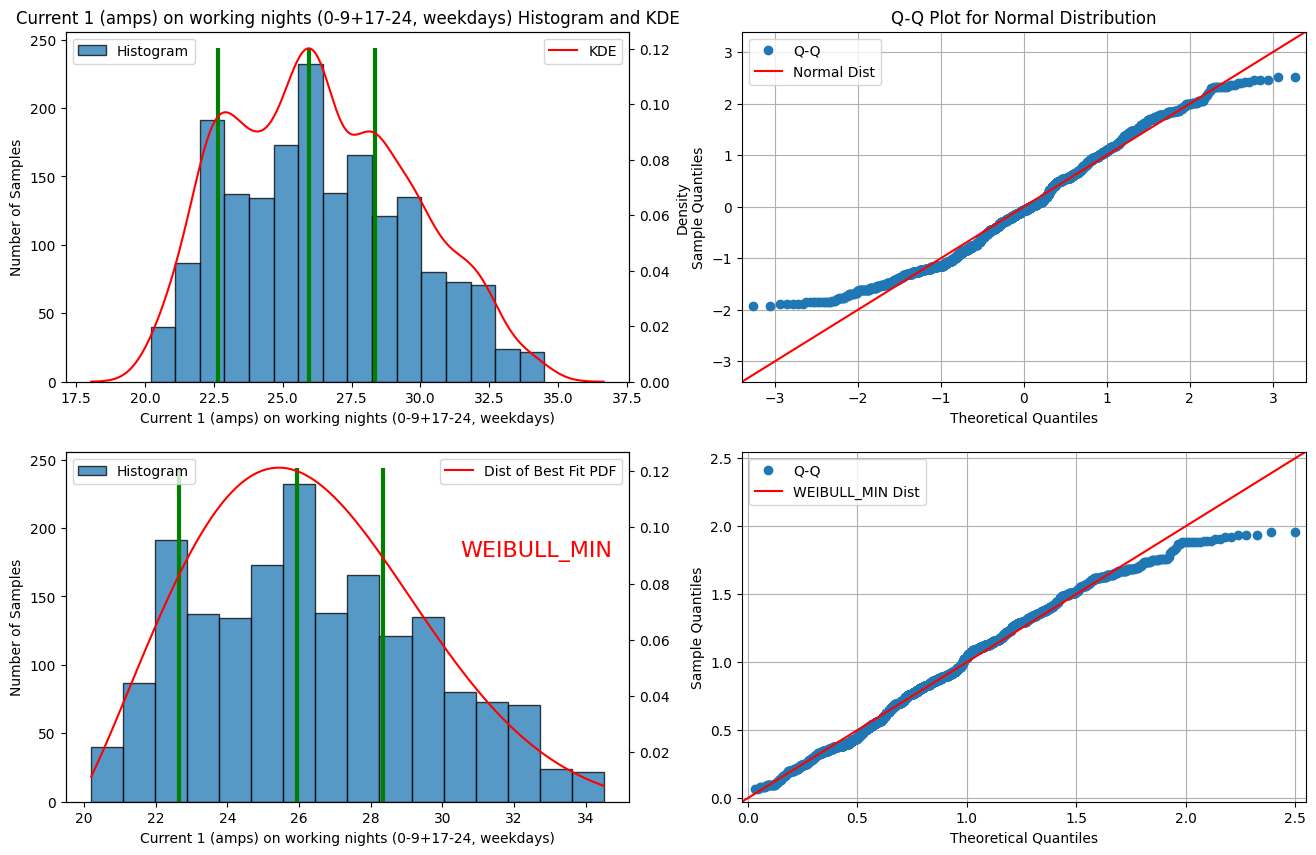

In [83]:
dl1_working_nights = []
for i in range(5):
    for j in list(range(0, 9))+list(range(17, 24)):
        dl1_working_nights += daily_hourly_samples[i][j]
dl1_working_nights = pd.Series(dl1_working_nights)
mylib.statistical_analysis(dl1_working_nights, bins=16, header=HEADER+' on working nights (0-9+17-24, weekdays)', modes=MODES)

##### Conclusions


#### Daily Average

DATASET STATISTICS:
Mean: 26.15332066869301
Standard Deviation: 2.709099643085386
Minimum Value: 21.261702127659575
25th Percentile: 24.01273339122883
Median: 26.222340425531918
75th Percentile: 28.180612244897958
Maximum: 32.10425531914894
Skewness: 0.16000296875849143
Kurtosis: -0.8116572849503587

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9705, p=0.06064053797776044
DAgostino and Pearsons Test: stat=4.9618, p=0.08366872027739174
Kolmogorov-Smirnov Test: stat=0.08462356336309729, p=0.5858148259647495

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 0.20233657848079778
p value for chi2 = 9.474904033649425e-08
p value for expon = 0.002928567270347515
p value for exponpow = 3.8862269563541295e-50
p value for gamma = 0.5659989855140154
p value for lognorm = 0.5403795621389215
p value for norm = 0.5632482990883048
p value for powerlaw = 0.010629840413336478
p value for rayleigh = 0.6442137914125255
p value for uniform = 0.05273205918497126
p value for arcsine = 0.00

c:\Users\ogahe\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis_eeedept\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 3.7752096609356267e-13
p value for weibull_max = 1.0232830405723049e-32
p value for weibull_min = 0.6141597934475651
p value for pareto = 0.0029285681852366796
p value for genextreme = 0.5655591944639263

Best fitting distribution: rayleigh
Best p value: 0.6442137914125255
Parameters for the best fit: (20.815263538211855, 4.2328521592683845)


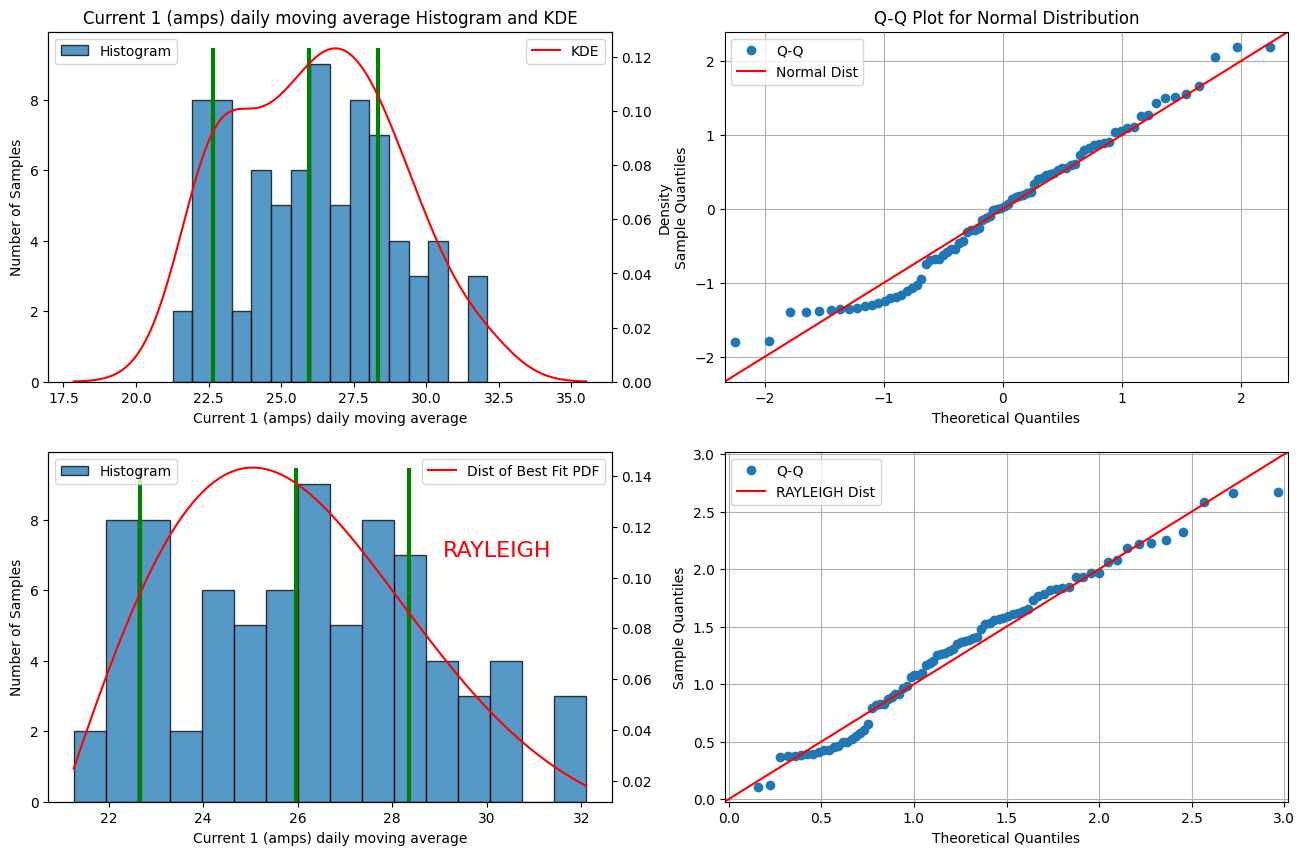

In [113]:
mylib.statistical_analysis(dl1[HEADER].groupby(dl1.index.round('1d')).mean(), bins=16, header=HEADER+' daily moving average', modes=MODES)

##### Conclusions


#### Weekly Average

DATASET STATISTICS:
Mean: 26.138806510864658
Standard Deviation: 2.13018581465352
Minimum Value: 23.485671641791043
25th Percentile: 24.107343992205145
Median: 26.209439557180982
75th Percentile: 27.61991723446272
Maximum: 29.834421364985165
Skewness: 0.21212098328546966
Kurtosis: -1.3768774821144332

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9109, p=0.21887440143853487
DAgostino and Pearsons Test: stat=2.5716, p=0.2764328951522101
Kolmogorov-Smirnov Test: stat=0.20279442019124105, p=0.6365428846196535

FITTING TO OTHER DISTRIBUTIONS: 
p value for cauchy = 0.6866177586203783
p value for chi2 = 0.015751988269736783
p value for expon = 0.5726655118168824
p value for exponpow = 0.2605289030950415
p value for gamma = 0.19540475809370172
p value for lognorm = 0.012839096662340177
p value for norm = 0.5765851087726506
p value for powerlaw = 0.07705356818908293
p value for rayleigh = 0.5022095620328346
p value for uniform = 0.26450637572974656


c:\Users\ogahe\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis_eeedept\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


p value for arcsine = 0.7253962032412886
p value for cosine = 0.4912956824446978
p value for expon = 0.5726655118168824
p value for weibull_max = 0.00235155565272534
p value for weibull_min = 0.6622392041610261
p value for dweibull = 0.9377265264134487
p value for t = 0.5761253097992964
p value for pareto = 0.0025058078973122034
p value for exponnorm = 0.5768716584410785
p value for lognorm = 0.012839096662340177
p value for norm = 0.5765851087726506


c:\Users\ogahe\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis_eeedept\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


p value for exponweib = 0.27406038942090183
p value for weibull_max = 0.00235155565272534
p value for weibull_min = 0.6622392041610261
p value for pareto = 0.0025058078973122034
p value for genextreme = 0.5984194996395278

Best fitting distribution: dweibull
Best p value: 0.9377265264134487
Parameters for the best fit: (2.380350148094279, 26.145756799350245, 2.190646823661199)


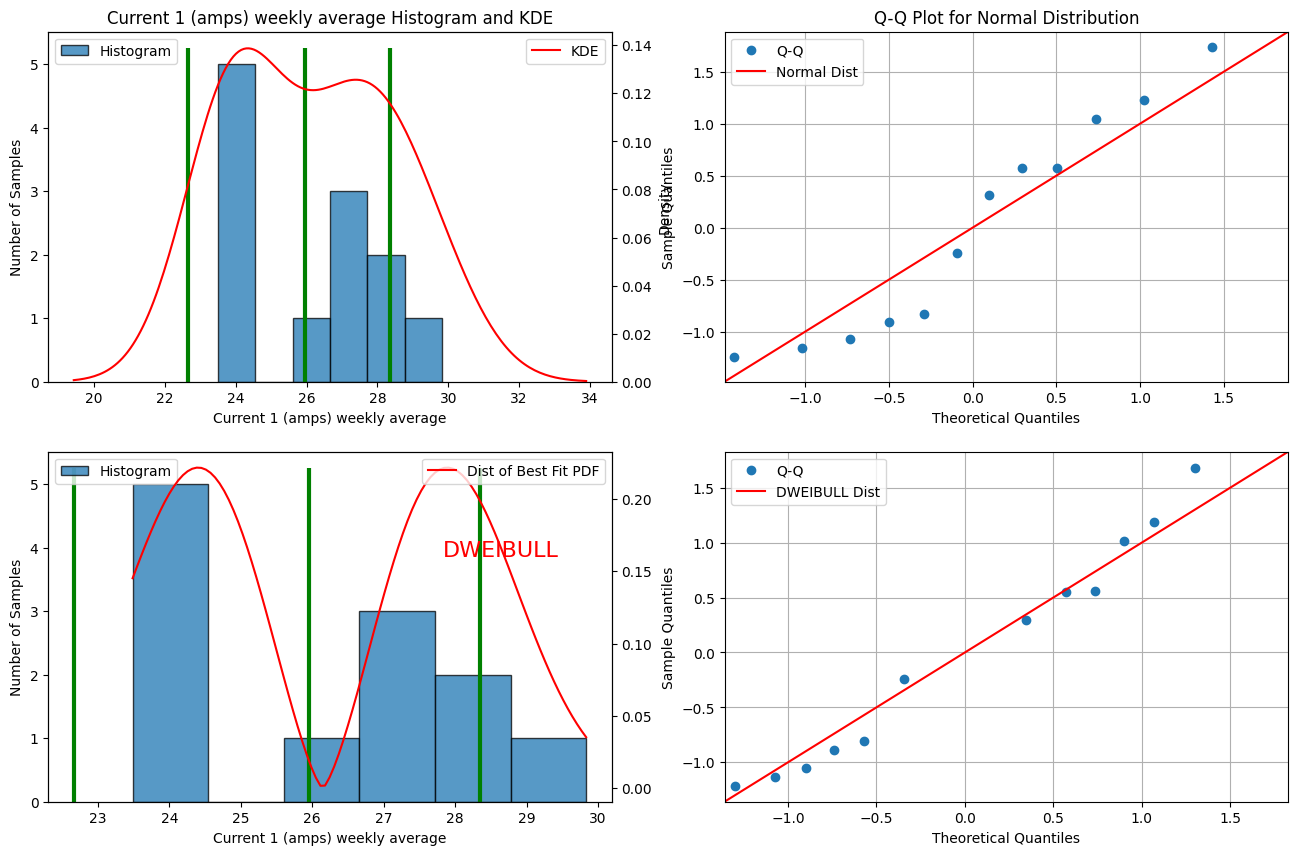

In [112]:
mylib.statistical_analysis(dl1[HEADER].groupby(dl1.index.round('7d')).mean(), bins=6, header=HEADER+' weekly average', modes=MODES)

In [85]:
HEADER = 'Power (kW)' # set it back to the way it was

## 4. CPU Usage Correlation
Thanks to Steven Richardson, we have some CPU usage data since August 23rd 2023 to August 14th 2024. We have this data for various servers including: Bermuda, Capsim, Pampas, Saintsaens1, Spinifex, Widor, Messiaen, and Bamboo. A sample was taken every minute or so. In this section, we will explore potential correlations between CPU Usage percentage and power consumption. Unfortunately, we are in the dark as to which server corresponds to which distribution board.

### Import Raw Data
As detailed in correspondance, only Bamboo, Bermuda, Pampas, and Spinifex have the correct data for the correct time frame we are analysing. For this reason, the rest will be omitted for now. We will truncate as necessary.

In [86]:
## Import Data
bamboo = pd.read_csv('../data/CPU-Data-ee-bamboo.csv')
bamboo['now'] = pd.to_datetime(bamboo['now'], utc=True)
bamboo = bamboo.set_index(bamboo['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-23 00:00:00+00:00')).reset_index(drop=True)

bermuda = pd.read_csv('../data/CPU-Data-ee-bermuda.csv')
bermuda['now'] = pd.to_datetime(bermuda['now'], utc=True)
bermuda = bermuda.set_index(bermuda['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-23 00:00:00+00:00')).reset_index(drop=True)

# capsim = pd.read_csv('../data/CPU-Data-ee-capsim.csv')
# capsim['now'] = pd.to_datetime(capsim['now'], utc=True)
# capsim = capsim.set_index(capsim['now'], drop=False)

# messiaen = pd.read_csv('../data/CPU-Data-ee-messiaen.csv')
# messiaen['now'] = pd.to_datetime(messiaen['now'], utc=True)
# messiaen = messiaen.set_index(messiaen['now'], drop=False)

pampas = pd.read_csv('../data/CPU-Data-ee-pampas.csv')
pampas['now'] = pd.to_datetime(pampas['now'], utc=True)
pampas = pampas.set_index(pampas['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                              after=pd.Timestamp('2024-05-23 00:00:00+00:00')).reset_index(drop=True)

# saintsaens = pd.read_csv('../data/CPU-Data-ee-saintsaens1.csv')
# saintsaens['now'] = pd.to_datetime(saintsaens['now'], utc=True)
# saintsaens = saintsaens.set_index(saintsaens['now'], drop=False)

spinifex = pd.read_csv('../data/CPU-Data-ee-spinifex.csv')
spinifex['now'] = pd.to_datetime(spinifex['now'], utc=True)
spinifex = spinifex.set_index(spinifex['now'], drop=False).truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                  after=pd.Timestamp('2024-05-23 00:00:00+00:00')).reset_index(drop=True)

# widor = pd.read_csv('../data/CPU-Data-ee-widor.csv')
# widor['now'] = pd.to_datetime(widor['now'], utc=True)
# widor = widor.set_index(widor['now'], drop=True)

## To Truncate: add .truncate(before=pd.Timestamp('2024-03-04 00:00:00+00:00'), 
                                                #   after=pd.Timestamp('2024-06-22 00:00:00+00:00'))

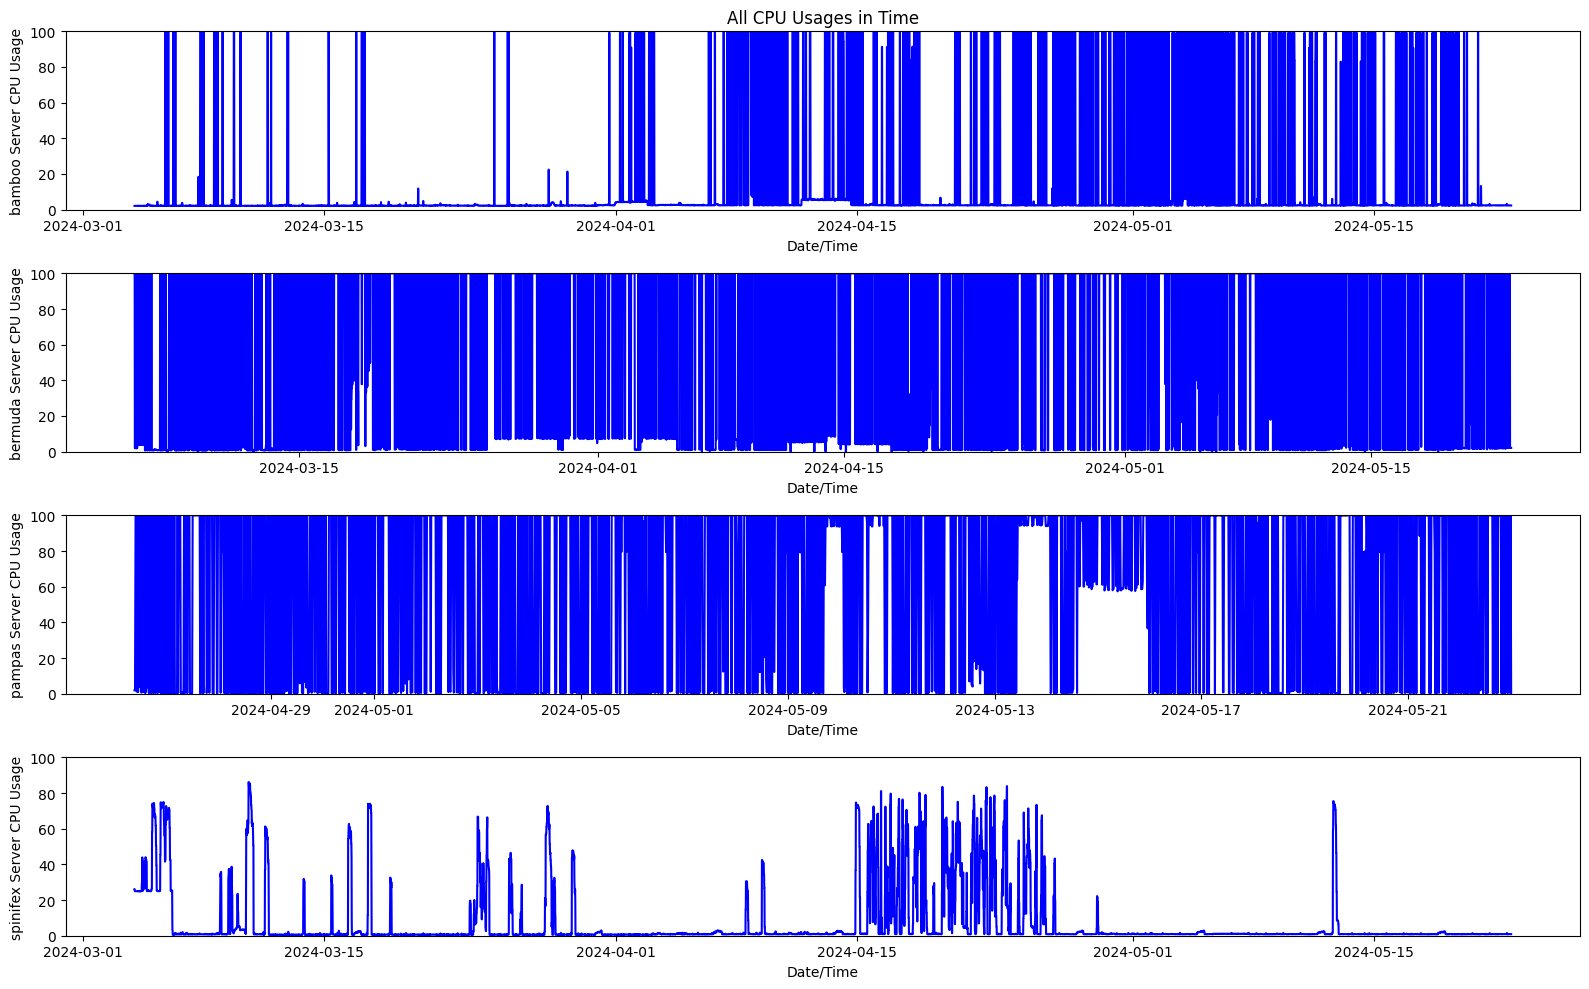

In [87]:
# server_names = {0: 'bamboo', 1: 'bermuda', 2: 'capsim', 3: 'messiaen', 4: 'pampas', 5: 'saintsaens', 6: 'spinifex', 7: 'widor'}
server_names = {0: 'bamboo', 1: 'bermuda', 2: 'pampas', 3: 'spinifex'}

fig, ax = plt.subplots(4, figsize=(16, 10))
for i in range(len(server_names)):
    ax[i].plot(eval(server_names[i])['now'], eval(server_names[i])['cpu.total'], color='b', linestyle='-')
    ax[i].set_xlabel('Date/Time')
    ax[i].set_ylabel(server_names[i] + ' Server CPU Usage')
    ax[i].set_ylim(0, 100)
ax[0].set_title("All CPU Usages in Time")
plt.tight_layout()
plt.show()

### Obtain Correlation Coefficients
In order to obtain a relatively reliable correlation coefficient, it is pertinent to average the CPU usages over the same sampling time as the power consumption. All samples have been taken approximately 15 minutes apart from each other: this has been empirically determined.

bamboo: 
nan
nan
bermuda: 
nan
nan
pampas: 
nan
nan
spinifex: 
nan
nan


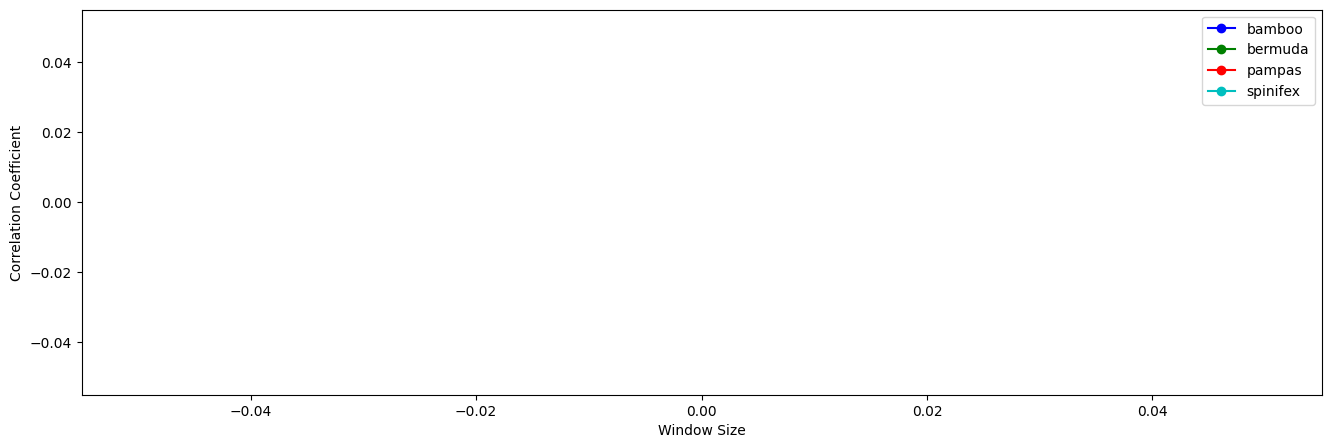

In [88]:
for name in server_names.values():
    eval(name)['cpu.av'] = eval(name)['cpu.total'].rolling(window=24*2).mean()
    print(name+": ")
    print(eval(name)['cpu.av'].corr(dl3[HEADER]))
    print(eval(name)['cpu.av'].corr(dl1[HEADER]))



# maxwindow = int(min([len(eval(name)) for name in server_names.values()])/2)
maxwindow = 24*2
step = 1
plt.figure(figsize=(16, 5))
for i in range(4):
    plt.plot(range(0, maxwindow, step), 
               [eval(server_names[i])['cpu.total'].rolling(window=j).mean().corr(dl1[HEADER]) for j in range(0, maxwindow, step)],
               color=colors[i], linestyle='-', marker='o', label=server_names[i])
plt.xlabel("Window Size")
plt.ylabel("Correlation Coefficient")
plt.legend(loc='upper right')
# plt.xticks(range(0, maxwindow, step), [str(k) for k in range(0, maxwindow, step)])
plt.show()

In [89]:
bamboo_averages = bamboo['cpu.total'].groupby(bamboo['now'].dt.round('30min')).mean().truncate(
    before=dl1["Date/Time"].iloc[0], after=dl1["Date/Time"].iloc[-1]
)
print(dl1[HEADER].corr(bamboo_averages))

-0.13650932387530296


## 5. Frequency Analysis

A possible idea could be to do an FFT: as we know the sample size is 30 mins, we can get an accurate reading of the frequency of the current, up to a precision of 1 hour<sup>-1</sup>.

It is interesting to remove the first element of the FFT, as this essentially removes the constant component. We are now left with only the varying parts

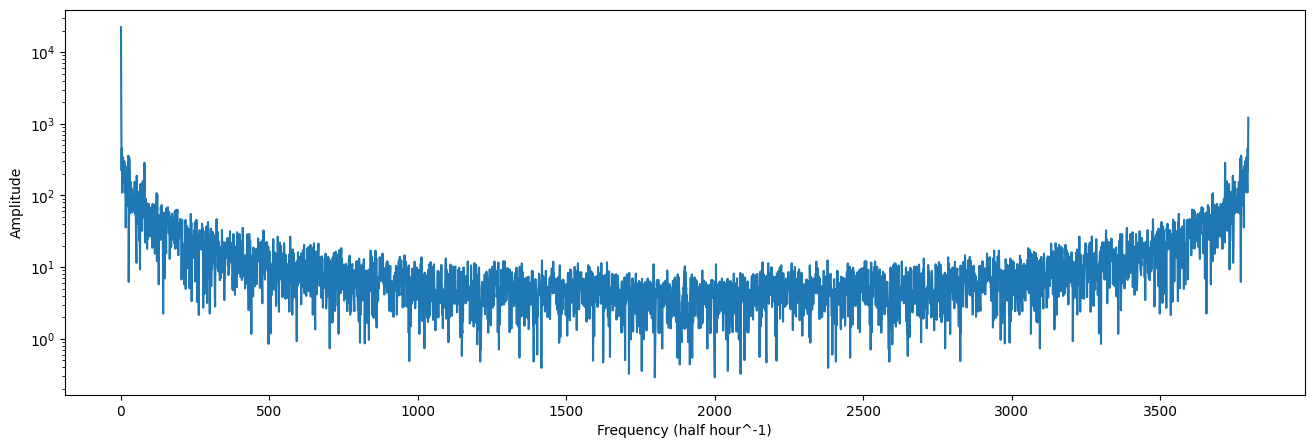

In [90]:
# dl1[HEADER + " Av Daily"] = dl1[HEADER].rolling(window=7).mean()
dl1_fft = fft.fft(np.array(dl1[HEADER].fillna(0.0))) # obtain FFT, remove constant term

# plot real part
plt.figure(figsize=(16, 5))
plt.plot(np.abs(dl1_fft))
# plt.xlim([0, 2*24*7])
# plt.vlines(x=range(0, 2*24*7, 24), ymin=0, ymax=5000, colors='r')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (half hour^-1)')
plt.yscale('log')
plt.show()